In [1]:
# Dependencies (Needs songephys environment)
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
#import umap
from scipy.stats.mstats import zscore
import h5py
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import glob
#from soundsig.sound import BioSound, WavFile, spectrogram
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import scipy.stats as stats

sys.path.append(os.path.join(os.getcwd(), "..", "code"))
#from cluster_functions import cluster_analysis
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score

import seaborn
seaborn.set(style="white")

# import helper functions
#from cluster_functions import cluster_analysis, plot_groupings, callColor, fine_to_coarse

%matplotlib inline
#summary = pk.load(open("/auto/zdrive/lthomas/summarySel.pkl",'rb'))

callColor = {
        'Be':(0/255.0, 230/255.0, 255/255.0),
        'Tu':(255/255.0, 200/255.0, 65/255.0),
        'Th':(255/255.0, 150/255.0, 40/255.0),
        'Alarm':(255/255.0, 200/255.0, 65/255.0),
        'Di':(255/255.0, 105/255.0, 15/255.0),
        'Ag':(255/255.0, 0/255.0, 0/255.0),
        'Fight':(255/255.0, 105/255.0, 15/255.0),
        'Wh':(255/255.0, 180/255.0, 255/255.0),
        'Ne':(255/255.0, 100/255.0, 255/255.0),
        'Te':(140/255.0, 100/255.0, 185/255.0),
        'Soft':(255/255.0, 180/255.0, 255/255.0),
        'DC':(100/255.0, 50/255.0, 200/255.0),
        'LT':(0/255.0, 95/255.0, 255/255.0),
        'Loud':(100/255.0, 50/255.0, 200/255.0),
        'song':(0, 0, 0),
        'So':(0,0,0), 
        'In': (0.49,0.60,0.55), 
        'Mo':(0.69,0.39,0.39)}

In [2]:

import google_auth_oauthlib.flow
from google.auth.transport.requests import Request
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
 
class Auth:
 
    def __init__(self, client_secret_filename, scopes):
        self.client_secret = client_secret_filename
        self.scopes = scopes
        self.flow = google_auth_oauthlib.flow.Flow.from_client_secrets_file(self.client_secret, self.scopes)
        self.flow.redirect_uri = 'http://localhost:8080/'
        self.creds = None
 
    def get_credentials(self):
        flow = InstalledAppFlow.from_client_secrets_file(self.client_secret, self.scopes)
        self.creds = flow.run_local_server(port=8080)
        return self.creds

 
# The scope you app will use. 
# (NEEDS to be among the enabled in your OAuth consent screen)
SCOPES = "https://www.googleapis.com/auth/drive.readonly"
CLIENT_SECRET_FILE = "/auto/zdrive/lthomas/Code/songephys/client_secrets.json"
 
credentials = Auth(client_secret_filename=CLIENT_SECRET_FILE, scopes=SCOPES).get_credentials()
 
drive_service = build('drive', 'v3', credentials=credentials)

def downloadfid(fid,outpath):
    cmd="curl -H \"Authorization: Bearer %s\" https://www.googleapis.com/drive/v3/files/%s?alt=media -o %s"%(credentials.token, fid,outpath)
    os.system(cmd)
def get_name_parent(fid):
    return drive_service.files().get(fileId=fid, fields='name, parents').execute()

def uploadfn(filename):
    media = MediaFileUpload(filename, mimetype="application/x-ustar", resumable=True)
    request = farm.animals().insert(media_body=media, body={'name': filename})
    response = None
    while response is None:
      status, response = request.next_chunk()
      if status:
        print("Uploaded %d%%." % int(status.progress() * 100))
    print( "Upload Complete!")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=225544822063-j9rve5uf6io3ihiivrbn2rvorb779eo1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&state=vqplZ2p0vWXEHnOQfm9ONLgMdYvV5y&access_type=offline


KeyboardInterrupt: 

In [7]:
results = drive_service.files().list(pageSize=10, q="name='HerminaDataBase.pkl'",fields="files(id, name,parents)").execute()
downloadfid(results['files'][0]['id'],'/auto/zdrive/lthomas/Code/zebra-finch-categories/data/ephys_Germany/HerminaDatabase.pkl')

In [2]:
# First load the data

numUnits = [1, 2, 3, 4, 5, 10, 20]
argList = []
pcc = []
confMat = []

for nUnit in numUnits:
    print("Downloading db for %d"%nUnit)
    results = drive_service.files().list(pageSize=10, q="name='HerminaDataBase%dGoodUnitPC.pkl'" % nUnit,fields="files(id, name,parents)").execute()
    downloadfid(results['files'][0]['id'],'/auto/zdrive/lthomas/Code/zebra-finch-categories/data/ephys_Germany/HerminaDatabase%dGoodUnitPC.pkl' % nUnit)


NameError: name 'drive_service' is not defined

In [3]:
# First load the data

numUnits = [1, 2, 3, 4, 5, 10, 20]
groupings = []
pcc = []
confMat = []
dataPath = '/auto/zdrive/lthomas/Code/zebra-finch-categories/data/ephys_Germany/'
for nUnit in numUnits:
    inPath = dataPath + 'HerminaDatabase%dGoodUnitPC.pkl' % nUnit
    fileIn = open(inPath,"rb")
    # groupings
    groupings.append(pk.load(fileIn))
    # conf matricies
    confMat.append(pk.load(fileIn))
    # percent correct scores for each grouping
    pcc.append(pk.load(fileIn))
    fileIn.close()

(array([5.000e+00, 6.800e+01, 1.096e+03, 3.659e+03, 3.453e+03, 1.310e+03,
        3.470e+02, 4.800e+01, 1.200e+01, 2.000e+00]),
 array([ 2.8350938 ,  7.64914264, 12.46319149, 17.27724033, 22.09128917,
        26.90533802, 31.71938686, 36.5334357 , 41.34748455, 46.16153339,
        50.97558223]),
 <BarContainer object of 10 artists>)

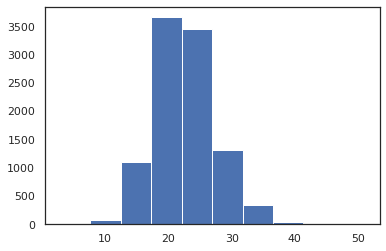

In [4]:
plt.hist(pcc[3])

In [6]:
#load acoustic clustering data
# load acoustic umap
# clus_fn = '/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable_clusters.h5'
clus_fn = '/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable_clusters_nonso.h5' #in 'clusters'
acoustic_clustering = pd.read_hdf(clus_fn,'clusters')
acoustic_clustering.head(5)

,filenames,groups_umap,calltype,umap00,umap01,umap02,umap03,umap04,umap05,umap06,umap07,umap08,umap09
0,BlaLbl8026_110607-WhineC-05,3,Wh,7.594182,8.898229,5.972304,2.689890,2.808550,5.398507,3.542738,5.879025,7.897853,2.479795
1,BlaLbl8026_110607-WhineC-04,2,Wh,6.854939,8.095228,6.306829,2.490242,2.726084,5.548801,3.715562,5.913951,7.411227,2.331845
2,BlaLbl8026_110607-WhineC-06,2,Wh,6.394282,7.696871,6.436657,2.400516,2.678924,5.540758,3.750131,5.926772,7.293443,2.274348
3,BlaLbl8026_110429-DC-11,5,DC,2.322118,2.293040,6.564301,4.563857,2.621046,4.944302,3.630900,5.587725,6.861681,2.473620
4,GraLbl0457_110509-NestC-03,1,Ne,7.608192,8.901046,5.348144,4.210425,3.108025,5.664823,3.787474,5.189566,7.454225,2.990023


In [7]:
dbHermina = pd.read_pickle('../data/ephys_Germany/HerminaDatabase.')

In [8]:
dbHermina.head()

,bird,site,unit,stim,call,trial,R,z,PC,PCdata
0,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,0,1.0,0.670113,"[-371.0872844018546, 67.70692230077675, 37.709...",NaN
1,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,1,-1.0,-0.670113,"[-390.8290974752949, -8.2528936987305, -4.9799...",NaN
2,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,2,1.0,0.670113,"[-381.22954095551694, -11.739478782847492, 33....",NaN
3,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_0_fs25k.wav,Ag,3,0.0,0.000000,"[-413.3700305165537, 19.789477797455923, 14.91...",NaN
4,ZF7F,ZF7F_5t_190720_152938,goodPlayback-e16-c1.pkl,BlaBla0506_MAF_Ag_1_fs25k.wav,Ag,0,0.0,0.000000,"[-413.3700305165537, 19.789477797455923, 14.91...",NaN


In [7]:
# this will be an example of doing this for one grouping just to see what we are dealin with
# first take a grouping near 95% pcc
pcen = np.percentile(pcc[1],95)
i_near=abs(pcc[3]-pcen).argmin()
grouping = groupings[3][i_near]

In [8]:
pcc

[array([14.87501034, 16.06273371, 16.45145497, 17.4972776 , 11.88122005,
        17.13381149, 12.17636718, 13.35950466, 14.63180932, 14.14193892,
        16.33091935, 15.90671819, 12.92347944, 13.51002144, 18.73741121,
        17.23568365, 13.87765224, 13.41379305, 13.14112002, 12.71535167,
        12.65971833, 12.81838549, 17.12085095, 12.98466178, 13.26706587,
        16.10906614, 12.74519036, 12.45595332, 11.61113586, 11.48552897,
        10.9005822 , 14.48237481, 11.33806313, 15.82730628, 13.24165497,
        14.66623365, 13.19892733, 14.78543078, 15.03725322, 10.28944453,
        12.42627962, 19.54100019, 12.69394281, 12.44019784, 14.94011865,
        12.72173253, 12.63671696, 11.43289129, 16.6432169 , 15.83595171,
        16.46310786, 13.58314938, 11.47948238, 10.91470118, 15.05398451,
        12.59234899, 10.55810436, 13.43479816, 13.85800586, 11.53289091,
        15.59606719, 25.35457504, 14.10486661, 11.08498735, 13.60404153,
        12.90001049, 12.30017388, 10.76016243, 10.8

In [9]:
# Attempt to optimize code above

import multiprocessing,time

stims = np.unique(dbHermina.stim)  
identities_orig = [x.split('_')[0] for x in stims]
calltypes_orig = [x.split('_')[2] for x in stims]
n_pcs = 5

def cluster_analysis_short(db_sites):
    avg_responses = np.zeros((len(stims),len(db_sites)*(1+n_pcs)))
    for ind, db_site in enumerate(db_sites):
        for stim in np.unique(db_site.stim):
            stim_ind = np.where(stims==stim)
            db_site_stim = db_site[db_site.stim == stim]
            avg_responses[stim_ind,ind*(1+n_pcs)] = np.mean(db_site_stim.z)
            n_trials[stim_ind,ind] = len(db_site_stim.z)
            for i in range(n_pcs):
                avg_responses[stim_ind,ind*(1+n_pcs)+i+1] = np.mean([x[i] for x in db_site_stim.PC])
    return cluster_analysis(avg_responses,calltypes_orig,use_umap=True,score='ari')# and_plot = True
        
#args = []

#result_dict = dict()
for i in range(len(groupings)):
    pccs_rand = []
    # take 500 random groupings
    #inds = np.random.choice(range(len(groupings[i])),min(len(groupings[i]),1000),replace=False)
    print(i)
    g_sites = []
    for g in range(len(groupings[i])): #inds:
        grp = groupings[i][g]
        p = pcc[i][g]
        #args.append(grp)
        pccs_rand.append(p)

        # response len will be (z,pc1,pc2...pcn) for each unit
        n_trials = np.zeros((len(stims),len(grp)))
        query = None
        sites = []
        for ind, g in enumerate(grp):
            s,g = g.split('_goodPlayback')
            query = (dbHermina.site == s)&(dbHermina.unit == 'goodPlayback%s'%g)
            db_site = dbHermina[query]
            sites.append(db_site.copy())
        g_sites.append(sites)

    print("starting multiproc for %s"%i)
    tst = time.time()
    pool = multiprocessing.Pool(12)
    results = pool.map(cluster_analysis_short,g_sites)       
    print("ending %s"%(time.time() - tst))
    #result_dict[i] = results
    pool.close()
    rd = dict()
    rd['pccs'] = pccs_rand
    rd['results'] = results
    rd['group'] = groupings[i]
    with open('../data/ephys_Germany/Groupings/Groupings_%s.pkl'%len(g_sites[0]), 'wb') as handle:
        pk.dump(rd, handle, protocol=pk.HIGHEST_PROTOCOL)


0
starting multiproc for 0


NameError: name 'cluster_analysis' is not defined

In [16]:
groups = glob.glob("../data/ephys_Germany/Groupings/Groupings_*.pkl")
# make a dataframe for easy processing
dfout = dict({
    'ari_calltype': [],
    'pcc_bayes': [],
    'group_size': []})
for gi, group_fp in enumerate(groups):
    group = pk.load(open(group_fp,'rb'))
    pccs = group['pccs']
    results = group['results']
    aris = [r[1] for r in results]
    dfout['ari_calltype'].extend(aris)
    dfout['pcc_bayes'].extend(pccs)
    dfout['group_size'].extend([len(groupings[gi][0])]*len(pccs))
dfout_f = pd.DataFrame(dfout)
dfout_f.to_hdf("../data/ephys_Germany/Groupings_metadata.hdf","ds")

In [1]:
import pandas as pd
import seaborn

In [2]:
dfout_f = pd.read_hdf("../data/ephys_Germany/Groupings_metadata.hdf",'ds')

In [3]:
dfout_f['group_size'].max()

20

/auto/fhome/lthomas/.virtualenvs/py39/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


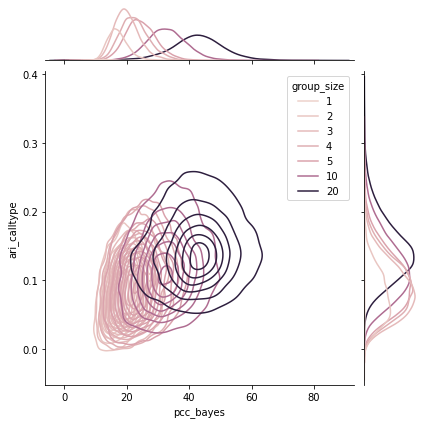

In [4]:
seaborn.jointplot(x='pcc_bayes',y='ari_calltype',hue='group_size',kind="kde",data=dfout_f)

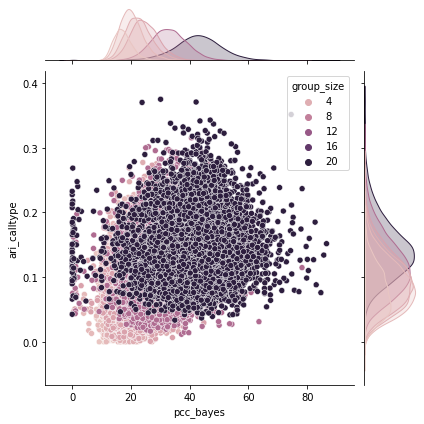

In [5]:
seaborn.jointplot(x='pcc_bayes',y='ari_calltype',hue='group_size',data=dfout_f)
plt.plot()

In [264]:
acoustic_clustering.head()

,calltype,filenames,groups_pca,groups_umap,pca1,pca2,umap1,umap2
0,Wh,BlaLbl8026_110607-WhineC-05,4,5,-1.159463,-1.132881,-1.005874,1.209956
1,Wh,BlaLbl8026_110607-WhineC-04,3,5,-1.578668,-2.116606,0.817599,0.590500
2,Wh,BlaLbl8026_110607-WhineC-06,3,5,-1.145136,-1.717987,1.280105,0.239141
3,DC,BlaLbl8026_110429-DC-11,3,1,1.112016,0.707791,6.123713,-2.425279
4,Ne,GraLbl0457_110509-NestC-03,4,5,-2.375957,-0.451540,-0.131751,3.354254


In [10]:
# because the stims are made up of multiple stims, We have to get the stim seg table
pdsegTable = pd.read_hdf("../data/ephys/StimSegTable.h5",'stim_seg')


In [12]:
aud_row

filenames      BlaBla0506_110304-AggC-07
groups_umap                            2
calltype                              Ag
umap00                           5.28155
umap01                           8.58179
umap02                           6.51555
umap03                            3.2029
umap04                           2.81833
umap05                           6.04522
umap06                           4.15951
umap07                           5.69363
umap08                           7.04817
umap09                           2.54496
Name: 128, dtype: object

In [ ]:
import numpy as np
# get umaps for stims in the order that was used
stims = np.unique(dbHermina.stim)
has_wavs = np.zeros(len(stims),dtype=np.bool)
aud_pcs = []
aud_umaps = []
lbls = []
aud_lbl_pc = []
aud_lbl_umap = []
for si, stim in enumerate(stims):
    # remove _fs25k.wav
    stim = stim[:-10]
    wavs = pdsegTable[pdsegTable.stimname==stim].sort_values('start')
    if len(wavs):
        first_wav = wavs.iloc[0]
        has_wavs[si] = 1
        aud_row = acoustic_clustering[acoustic_clustering.filenames == first_wav.wav].iloc[0]
        lbls.append(aud_row.calltype)
        aud_lbl_pc.append(aud_row.groups_pca)
        aud_lbl_umap.append(aud_row.groups_umap)
        aud_pcs.append([aud_row.pca1, aud_row.pca2])
        aud_umaps.append([aud_row.umap1, aud_row.umap2])
    else:
        has_wavs[si] = 0
        print("Stim: %s \t Wav: None"%stim)
aud_pcs = np.asarray(aud_pcs)
aud_umaps = np.asarray(aud_umaps)

In [14]:
import numpy as np
# get umaps for stims in the order that was used
stims = np.unique(dbHermina.stim)
has_wavs = np.zeros(len(stims),dtype=np.bool)
#aud_pcs = []
aud_umaps = []
lbls = []
#aud_lbl_pc = []
aud_lbl_umap = []
for si, stim in enumerate(stims):
    # remove _fs25k.wav
    stim = stim[:-10]
    wavs = pdsegTable[pdsegTable.stimname==stim].sort_values('start')
    if len(wavs):
        first_wav = wavs.iloc[0]
        has_wavs[si] = 1
        aud_row = acoustic_clustering[acoustic_clustering.filenames == first_wav.wav].iloc[0]
        lbls.append(aud_row.calltype)
        #aud_lbl_pc.append(aud_row.groups_pca)
        aud_lbl_umap.append(aud_row.groups_umap)
        #aud_pcs.append([aud_row.pca1, aud_row.pca2])
        #aud_umaps.append([aud_row.umap1, aud_row.umap2])
        aud_umaps.append([aud_row['umap%.2d'%i] for i in range(10)])
    else:
        has_wavs[si] = 0
        print("Stim: %s \t Wav: None"%stim)
#aud_pcs = np.asarray(aud_pcs)
aud_umaps = np.asarray(aud_umaps)

<ipython-input-14-e268ddea21ff>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  has_wavs = np.zeros(len(stims),dtype=np.bool)


IndexError: single positional indexer is out-of-bounds

In [272]:
import glob,time
import pickle as pk
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score

groups = glob.glob("../data/ephys_Germany/Groupings/Groupings_*.pkl")
# make a dataframe for easy processing
dfout_add = dict({
    'neural_grouping': [],
    'ari_neural_vs_aud': []})
for gi, group_fp in enumerate(groups):
#def proc_group_pf(group_fp):
    print("Starting %s"%group_fp)
    tst = time.time()
    group = pk.load(open(group_fp,'rb'))
    pccs = group['pccs']
    results = group['results']
    neural_groupings = [r[4] for r in results]
    
    n_v_a_aris = [ adjusted_rand_score(ng[has_wavs],aud_lbl_umap) if ng is not None else 0.0 for ng in neural_groupings]
    dfout_add['neural_grouping'].extend(neural_groupings)
    dfout_add['ari_neural_vs_aud'].extend(n_v_a_aris)
    print("Finished %s in %s"%(group_fp,time.time()-tst))
    #return results[0][4], adjusted_rand_score(results[0][4][has_wavs],aud_lbl_umap)



dfout_f['neural_grouping'] =  dfout_add['neural_grouping']# = pd.DataFrame(dfout)
dfout_f['ari_neural_vs_aud'] = dfout_add['ari_neural_vs_aud']#
dfout_f.to_hdf("../data/ephys_Germany/Groupings_metadata_with_ng.hdf",'data')

Starting ../data/ephys_Germany/Groupings/Groupings_1.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_1.pkl in 0.15503501892089844
Starting ../data/ephys_Germany/Groupings/Groupings_2.pkl


KeyboardInterrupt: 

In [282]:
group = pk.load(open("../data/ephys_Germany/Groupings/Groupings_1.pkl",'rb'))
aud_lbl_umap
arimax = 0
for grouping in group['results'][1][3]:
    ari = adjusted_rand_score(grouping[has_wavs],aud_lbl_umap)
    if ari > arimax:
        arimax=ari

In [285]:
adjusted_rand_score(group['results'][1][4][has_wavs],aud_lbl_umap) - arimax

-0.02465511646899033

In [73]:
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb


In [182]:
umaps_tot = np.asarray([acoustic_clustering.umap1,acoustic_clustering.umap2]).T

In [ ]:
norm_aud_umaps = (aud_umaps - np.min(umaps_tot,axis=0))/(np.max(umaps_tot,axis=0)-np.min(umaps_tot,axis=0))
aud_ab = (norm_aud_umaps*255).astype(np.int) - 128
aud_lab = []
for ab in norm_aud_umaps:
    aud_lab.append([.5,ab[0],ab[1]])
aud_lab = np.asarray(aud_lab)

In [184]:
norm_aud_umaps = (aud_umaps - np.min(umaps_tot,axis=0))/(np.max(umaps_tot,axis=0)-np.min(umaps_tot,axis=0))
aud_ab = (norm_aud_umaps*255).astype(np.int) - 128
aud_lab = []
for ab in norm_aud_umaps:
    aud_lab.append([.5,ab[0],ab[1]])
aud_lab = np.asarray(aud_lab)

In [112]:
len(norm_aud_umaps)

98

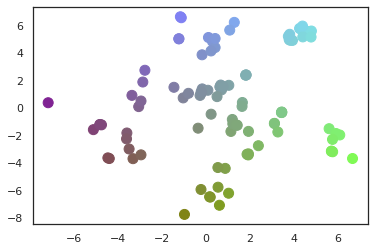

In [185]:
plt.scatter(aud_umaps[:,0],aud_umaps[:,1],c=aud_lab,s=100)

In [239]:
ca

TypeError: only integer scalar arrays can be converted to a scalar index

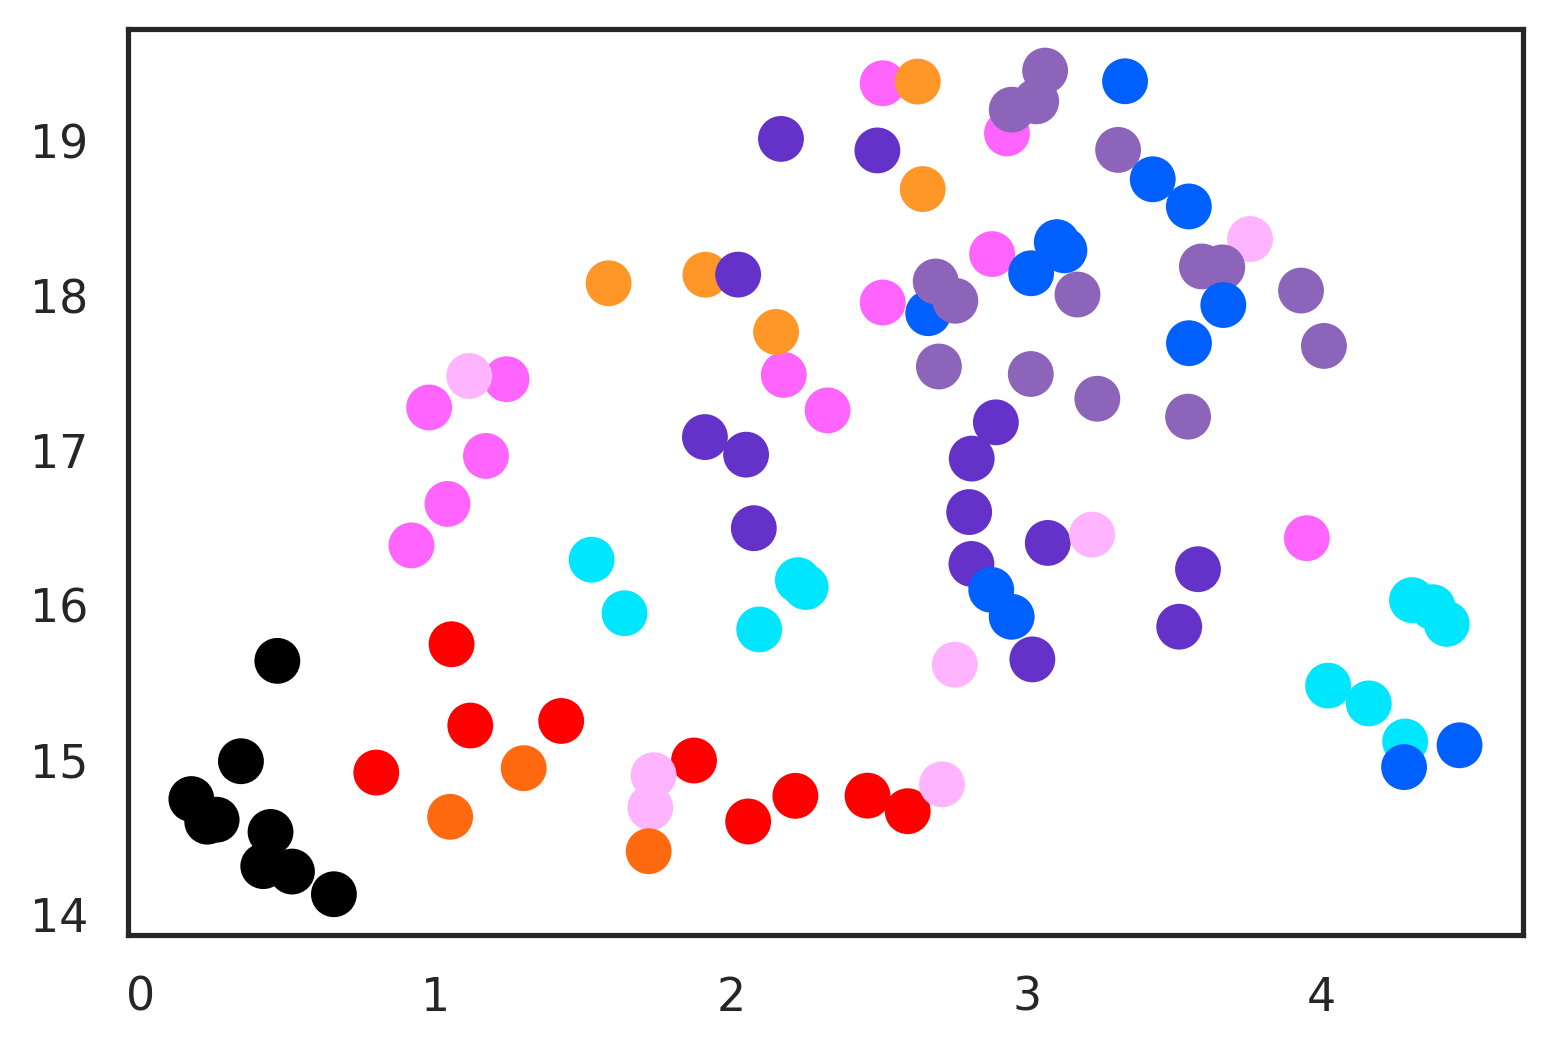

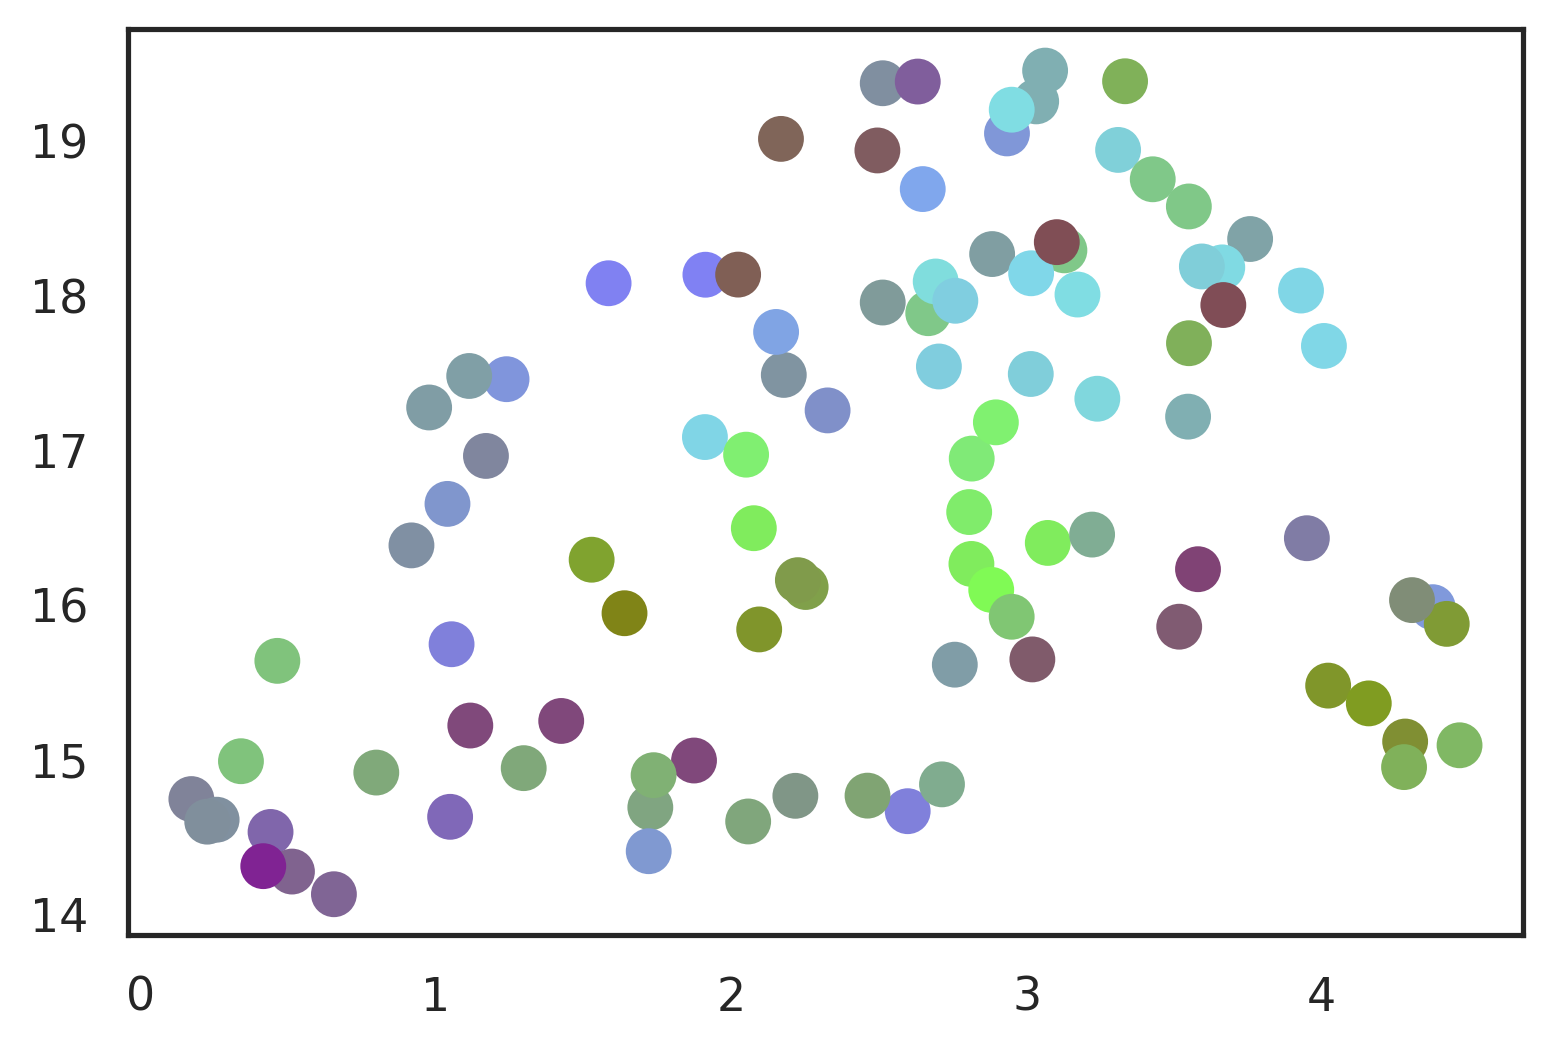

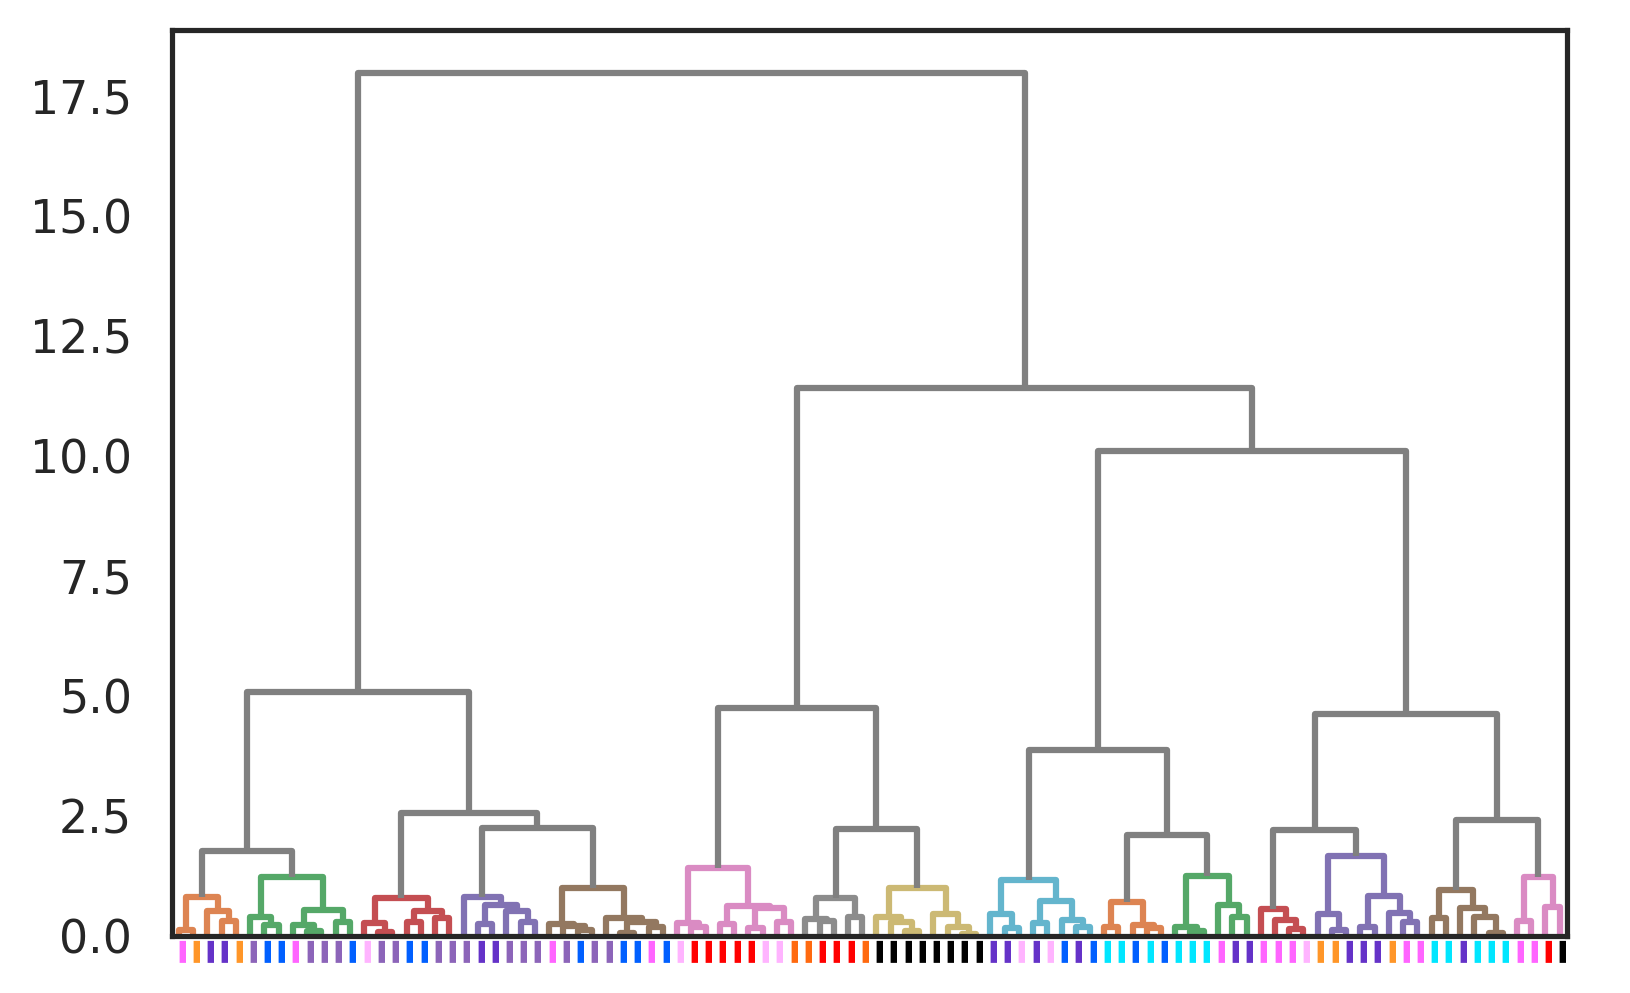

In [269]:
gs = 20
group = pk.load(open('../data/ephys_Germany/Groupings/Groupings_%s.pkl'%gs,'rb'))
pccs = group['pccs']
results = group['results']
neural_groupings = [r[4] for r in results]
aris = np.array([r[1] for r in results])
umaps_neur = [r[2] for r in results]
cts = [r[-1] for r in results]
calltypes_orig = np.asarray([x.split('_')[2] for x in stims])
#ind = np.argmax(aris)
#ind = numpy.percentile(aris,95)
pcen = np.percentile(aris,95)
ind = np.random.choice(np.where(aris>pcen)[0])

plt.figure(figsize= (6,4),dpi=300)
plt.scatter(umaps_neur[ind][has_wavs,0],umaps_neur[ind][has_wavs,1],c=[callColor.get(x) for x in calltypes_orig[has_wavs]],s=100)
plt.savefig("Figs/Group%smax_labels.eps"%gs,transparent=True)

plt.figure(figsize= (6,4),dpi=300)
plt.scatter(umaps_neur[ind][has_wavs,0],umaps_neur[ind][has_wavs,1],c=aud_lab,s=100)
plt.savefig("Figs/Group%smax.eps"%gs,transparent=True)

clustered=linkage(umaps_neur[ind][has_wavs,:],method ='ward')
plt.figure(figsize= (6,4),dpi=300)
D = dendrogram(Z=clustered, leaf_rotation=90.,
     leaf_font_size=20., # determine number by plotting cluster colors on leaves first
     #labels= results[max_ari_ind][1], #finesem_calls[1:7633],
     labels=calltypes_orig[has_wavs], #voc_types,#plottinglabels,
     color_threshold= cts[ind],
     above_threshold_color='grey')
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
newlab = []
for t in xlbls:
    t.set_color(callColor.get(t.get_text(),(0,0,0)))
    newlab.append('-')
ax.set_xticklabels(newlab)
ax.tick_params(axis="x",direction="in", pad=-1)

plt.savefig("Figs/Group%sdend.eps"%gs,transparent = True)

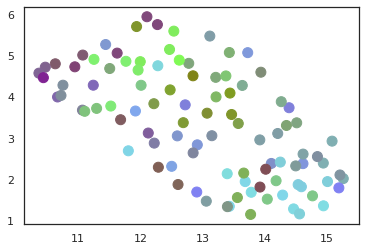

In [256]:
gs = 20
#FIND ME
group = pk.load(open('../data/ephys_Germany/Groupings/Groupings_%s.pkl'%gs,'rb'))
pccs = group['pccs']
results = group['results']
neural_groupings = [r[4] for r in results]
aris = np.array([r[1] for r in results])
umaps_neur = [r[2] for r in results]
#ind = np.argmax(aris)
#ind = numpy.percentile(aris,95)
pcen = np.percentile(aris,95)

#ind=abs(aris-pcen).argmin()
ind = np.random.choice(np.where(aris>pcen)[0])
plt.scatter(umaps_neur[ind][has_wavs,0],umaps_neur[ind][has_wavs,1],c=aud_lab,s=100)
plt.savefig("Figs/Group%smax.eps"%gs,transparent=True)

In [249]:
calltypes_orig[has_wavs]

array(['Ag', 'Ag', 'Ag', 'DC', 'DC', 'DC', 'Ne', 'Ne', 'Ne', 'So', 'So',
       'So', 'Te', 'Te', 'Te', 'Th', 'Th', 'Wh', 'Wh', 'Wh', 'Ag', 'Ag',
       'Ag', 'DC', 'DC', 'DC', 'Di', 'Di', 'Di', 'Ne', 'Ne', 'Ne', 'Te',
       'Te', 'Te', 'Ag', 'Ag', 'Ag', 'DC', 'DC', 'DC', 'Ne', 'Ne', 'So',
       'So', 'So', 'Te', 'Te', 'Te', 'DC', 'DC', 'DC', 'Ne', 'Ne', 'Ne',
       'So', 'So', 'So', 'Te', 'Te', 'Te', 'Wh', 'Wh', 'Wh', 'Be', 'Be',
       'Be', 'LT', 'LT', 'LT', 'Be', 'Be', 'Be', 'LT', 'LT', 'LT', 'Be',
       'Be', 'Be', 'LT', 'LT', 'LT', 'LT', 'Be', 'Be', 'LT', 'LT', 'LT',
       'DC', 'DC', 'Ne', 'Te', 'Te', 'Te', 'Th', 'Th', 'Th', 'Wh'],
      dtype='<U2')

In [195]:
np.random.choice(np.where(aris>pcen)[0])

48

In [69]:
np.min(aud_umaps,axis=0)

array([-7.1924615, -7.7620935], dtype=float32)

In [39]:
dfout_f = pd.read_hdf("../data/ephys_Germany/Groupings_metadata_with_ng.hdf",'data')

FileNotFoundError: File ../data/ephys_Germany/Groupings/Groupings_metadata_with_ng.hdf does not exist

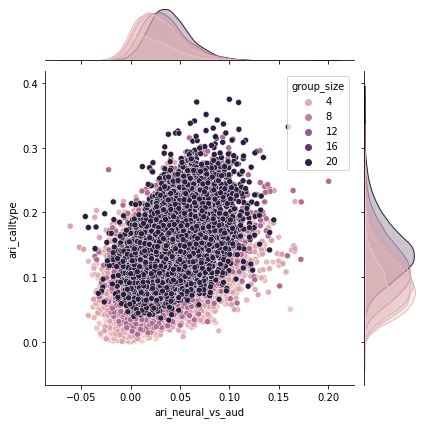

In [25]:
seaborn.jointplot(x='ari_neural_vs_aud',y='ari_calltype',hue='group_size',data=dfout_f)

In [7]:
seaborn.kdeplot(dfout_f['ari_calltype']-dfout_f['ari_neural_vs_aud'],hue=dfout_f['group_size'])#,data=dfout_f)

NameError: name 'dfout_f' is not defined

In [6]:
seaborn.jointplot(x=dfout_f['pcc_bayes'],y=dfout_f['ari_calltype']-dfout_f['ari_neural_vs_aud'],hue=dfout_f['group_size'])#,data=dfout_f)

KeyError: 'ari_neural_vs_aud'

/auto/fhome/lthomas/.virtualenvs/py39/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


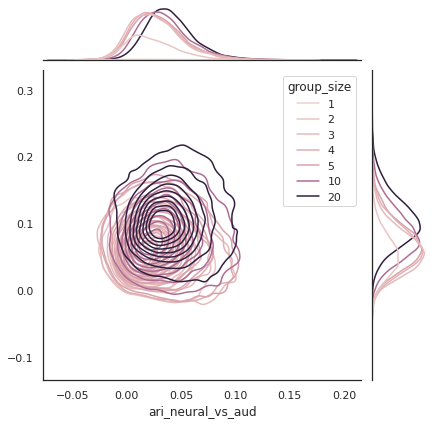

In [85]:
seaborn.jointplot(x=dfout_f['ari_neural_vs_aud'],y=dfout_f['ari_calltype']-dfout_f['ari_neural_vs_aud'],hue=dfout_f['group_size'],kind='kde')#,data=dfout_f)

/auto/fhome/lthomas/.virtualenvs/py39/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

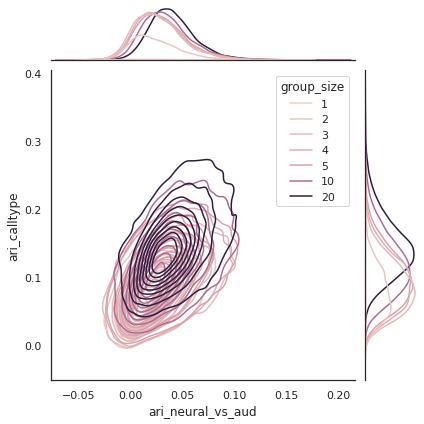

In [80]:
seaborn.jointplot(x='ari_neural_vs_aud',y='ari_calltype',hue='group_size',kind='kde',data=dfout_f)
plt.plot

/auto/fhome/lthomas/.virtualenvs/py39/lib/python3.9/site-packages/seaborn/distributions.py:1181: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


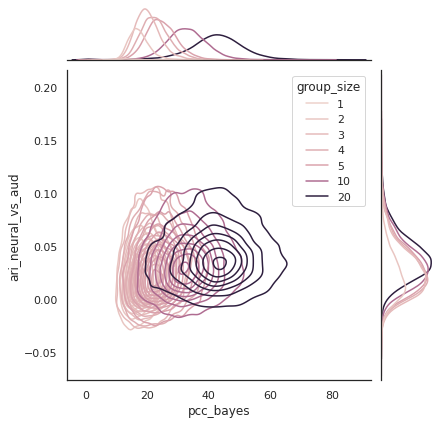

In [77]:
seaborn.jointplot(y='ari_neural_vs_aud',x='pcc_bayes',hue='group_size',kind='kde',data=dfout_f)


In [34]:
dfout_f.head()

,ari_calltype,group_size,pcc_bayes,neural_grouping,ari_neural_vs_aud
0,0.056665,1,14.875010,"[5, 6, 6, 3, 4, 5, 1, 7, 1, 5, 6, 4, 7, 1, 7, ...",0.029546
1,0.132419,1,16.062734,"[3, 4, 2, 4, 2, 3, 2, 1, 1, 2, 4, 2, 1, 2, 1, ...",0.050850
2,0.077305,1,16.451455,"[2, 2, 1, 6, 4, 2, 5, 4, 4, 2, 2, 2, 3, 3, 5, ...",0.000553
3,0.102909,1,17.497278,"[6, 6, 1, 6, 6, 4, 6, 4, 2, 1, 4, 1, 3, 6, 2, ...",0.027153
4,0.062246,1,11.881220,"[3, 2, 3, 3, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1, 1, ...",0.015749


In [37]:
#aud_lbl_umap, aud_umaps
aud_umaps

array([[ 1.4144195 , -1.2655741 ],
       [-1.2432427 ,  5.0330157 ],
       [-1.2432427 ,  5.0330157 ],
       [-5.1344824 , -1.5862128 ],
       [-3.6094782 , -1.8293804 ],
       [-3.6255116 , -2.2563722 ],
       [ 0.10351666,  5.1284227 ],
       [ 0.28730074,  4.835296  ],
       [ 0.7000906 ,  1.3149414 ],
       [-1.0468845 ,  0.7269664 ],
       [ 3.1056952 , -1.1319958 ],
       [ 3.1056952 , -1.1319958 ],
       [ 1.7957704 ,  2.3829057 ],
       [ 1.8160878 ,  2.3983629 ],
       [ 1.8162671 ,  2.397315  ],
       [-1.1324627 ,  6.567849  ],
       [-1.1742601 ,  6.6395926 ],
       [ 1.0297725 ,  1.6446557 ],
       [ 0.66036004,  1.6635492 ],
       [ 1.1906487 , -0.8443565 ],
       [ 1.1257994 , -1.716883  ],
       [-4.7656918 , -1.2358279 ],
       [ 1.2130886 , -1.1658494 ],
       [ 4.250941  ,  5.7859607 ],
       [ 5.5955954 , -1.5151763 ],
       [ 6.080187  , -1.9735696 ],
       [ 1.3753839 , -1.2561487 ],
       [-2.789474  ,  2.7404585 ],
       [ 0.40658128,

In [22]:
pccs_rand = np.asarray(pccs_rand)
grp_size = np.asarray([len(g) for g in args])
aris = np.concatenate([[r[1] for r in result_dict[results]] for results in result_dict])

In [13]:
# OLD CODE
def proc_grouping(grouping):
    # Take average across trials for each stim
    stims = np.unique(dbHermina.stim)
    n_pcs = 5
    # response len will be (z,pc1,pc2...pcn) for each unit
    avg_responses = np.zeros((len(stims),len(grouping)*(1+n_pcs)))
    n_trials = np.zeros((len(stims),len(grouping)))

    for ind, g in enumerate(grouping):
        s,g = g.split('_goodPlayback')
        query = (dbHermina.site == s)&(dbHermina.unit == 'goodPlayback%s'%g)
        db_site = dbHermina[query]
        for stim in np.unique(db_site.stim):
            stim_ind = np.where(stims==stim)
            db_site_stim = db_site[query&(db_site.stim == stim)]
            avg_responses[stim_ind,ind*(1+n_pcs)] = np.mean(db_site_stim.z)
            n_trials[stim_ind,ind] = len(db_site_stim.z)
            for i in range(n_pcs):
                avg_responses[stim_ind,ind*(1+n_pcs)+i+1] = np.mean([x[i] for x in db_site_stim.PC])
    identities_orig = [x.split('_')[0] for x in stims]
    calltypes_orig = [x.split('_')[2] for x in stims]
    ret = cluster_analysis(avg_responses,calltypes_orig,use_umap=True,score='ari')# and_plot = True
    return ret, calltypes_orig

args = []
pccs_rand = []
for i in range(1):#range(len(groupings)):
    # take 500 random groupings
    inds = np.random.choice(range(len(groupings[i])),min(len(groupings[i]),5000),replace=False)
    for g in inds:#:range(len(groupings[i]))
        grp = groupings[i][g]
        p = pcc[i][g]
        args.append(grp)
        pccs_rand.append(p)
       # r = proc_grouping(grp)



In [134]:
list(range(1))

[0]

In [136]:
print("starting multiproc for %s"%i)
tst = time.time()

import multiprocessing
pool = multiprocessing.Pool(12)
results = pool.map(proc_grouping,args)
print("ending %s"%(time.time() - tst))


starting multiproc for 0


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to matc

-------------
ARI: 0.0469121484699871
-------------
ARI: 0.06860639749862439
-------------
ARI: 0.08585360792654459
-------------
ARI: 0.03436751410246503


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.02329033839437258


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.006655385284413722


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
-------------
ARI: 0.03570115825734081
ARI: 0.05067914162276231
-------------
ARI: 0.1131299381528719
-------------
ARI: 0.019677802723635403


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.1277154207243952


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.005949144966783346


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.08774279973208306


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.005653309970561425
-------------
ARI: 0.13353300995035736
-------------
ARI: 0.05484238301195928
-------------
ARI: 0.08734457174064564
-------------
ARI: 0.09382986998555397
-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.048783041088720225
-------------
ARI: 0.09970958373668927
-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.09939239366889205


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.08993616800782005


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to matc

-------------
ARI: 0.062055513055351536
-------------
ARI: 0.01858447511850958


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.06387301537971463
-------------
ARI: 0.036333767694096276


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
-------------
ARI: 0.03662202171625446
ARI: 0.044816541963641314
-------------
ARI: 0.02576316469765385


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.026541190309892288
-------------
ARI: 0.036502649306256255
-------------
ARI: 0.11073115403497485


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.04311130001821605


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.09009728985068775
-------------
ARI: 0.024995345145546938


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.08334938000514572


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.07521186440677967


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.05998943729730982


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.09029335142062989
-------------
ARI: 0.05012403327010068
-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.0332177521739724
-------------
ARI: 0.08521509070349222


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.0529065030677231


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.034758583050500565
-------------
ARI: 0.12562994409379044
-------------
ARI: 0.06274550817926879


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.030468278967897538
-------------
ARI: 0.10108223014728125


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.029072852598382753
-------------
ARI: 0.06658067974337929


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.033344121979972226


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.018336370948104756


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
-------------
ARI: 0.05782115261980306
ARI: 0.030456677406258896
-------------
ARI: 0.08330467482216083
-------------
ARI: 0.022219220362433643


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.01657925272685077


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.08179564090896428
-------------
ARI: 0.06712602916012572


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.0518272050530115


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.06573036364496146


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.04791620824715046


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.02573520087171784
-------------
ARI: 0.05990102389144871


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.06805669612204815
-------------
ARI: 0.12808930475024594


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.05566793205685942


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.016434645886174007


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.15112866074366568


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.06296813912641276


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.10056400188891627
-------------
ARI: 0.04717219169190204
-------------
ARI: 0.06854207756158137


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.039357845675815635


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.03934547606943284
-------------
ARI: 0.1449409115722073


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.10346568478130276


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.05732261447046486
-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.13616666642017414
-------------


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


ARI: 0.09251265257517119


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.06044549705681513
-------------
ARI: 0.07386308047263852


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.03156268479401626


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.06515966624650828
-------------
ARI: 0.06854887942702313


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.056310992640580655


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.07241457739209546


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.03998184443809284
-------------
ARI: 0.08850872074509744


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.1284852131505015


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.0563226267852313


/auto/fhome/lthomas/.virtualenvs/py3_env/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


-------------
ARI: 0.059467321586113155
-------------
ARI: 0.08670366889854733
-------------
ARI: 0.09411951055320161
-------------
ARI: 0.05502392344497608
-------------
ARI: 0.08700724665174336
-------------
ARI: 0.027507063029727226
-------------
ARI: 0.07311926820340336
-------------
ARI: 0.03584802774813063
-------------
ARI: 0.02177949975927922
ending 66.52976775169373


In [23]:
import scipy.stats as stats
grp_size.max()

20

0.004852411321110363 -0.004255932131866029
0.0033044947722142325 0.021263028502435458
0.0021071045922532797 0.043657073817821225
0.0014678192286813113 0.059159385913598074
0.001482843703901284 0.06257920473714396
0.0006173926518565062 0.10016882998628147
-4.299096527323778e-05 0.14718563089055894


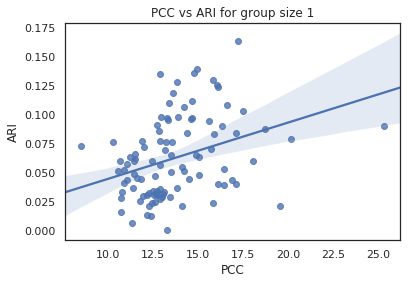

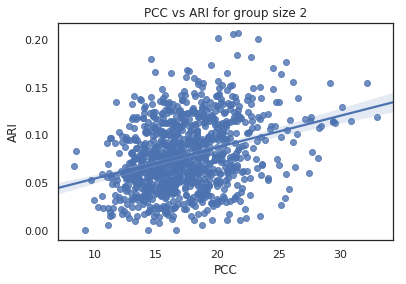

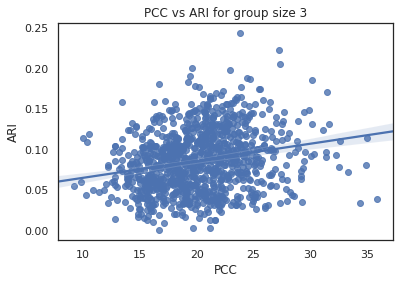

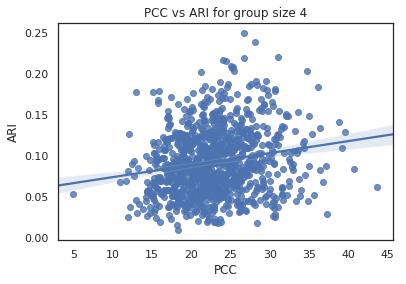

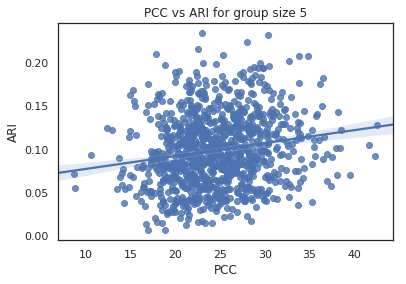

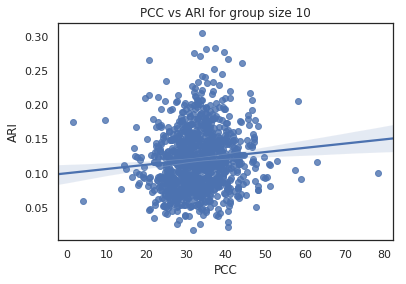

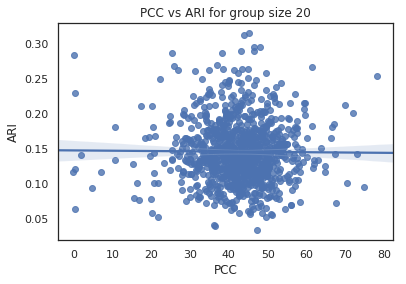

In [24]:
for gs in np.unique(grp_size):
    plt.figure()
    plt.title("PCC vs ARI for group size %s"%(gs))
    #seaborn.regplot(x=np.log10(pccs_rand[grp_size == gs+1]), y =aris[grp_size == gs+1] )
    slope, intercept, r_value, pv, se = stats.linregress(pccs_rand[grp_size == gs], aris[grp_size == gs])
    print(slope,intercept)
    seaborn.regplot(pccs_rand[grp_size == gs], aris[grp_size == gs], line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})

    plt.xlabel("PCC")
    plt.ylabel("ARI")
    #plt.scatter(pccs_rand[grp_size == gs+1],aris[grp_size == gs+1])

In [10]:
bxpl= []
for gs in np.unique(grp_size):
    bxpl.append(aris[grp_size == gs])

fig = plt.figure()
ax = plt.gca()
plt.title("ARI vs group size")
plt.ylabel("ARI")
plt.xlabel("Group Size")
_ =seaborn.boxplot(bxpl)
ax.set_xticklabels(np.unique(grp_size))

    #plt.scatter(pccs_rand[grp_size == gs+1],aris[grp_size == gs+1])

NameError: name 'grp_size' is not defined

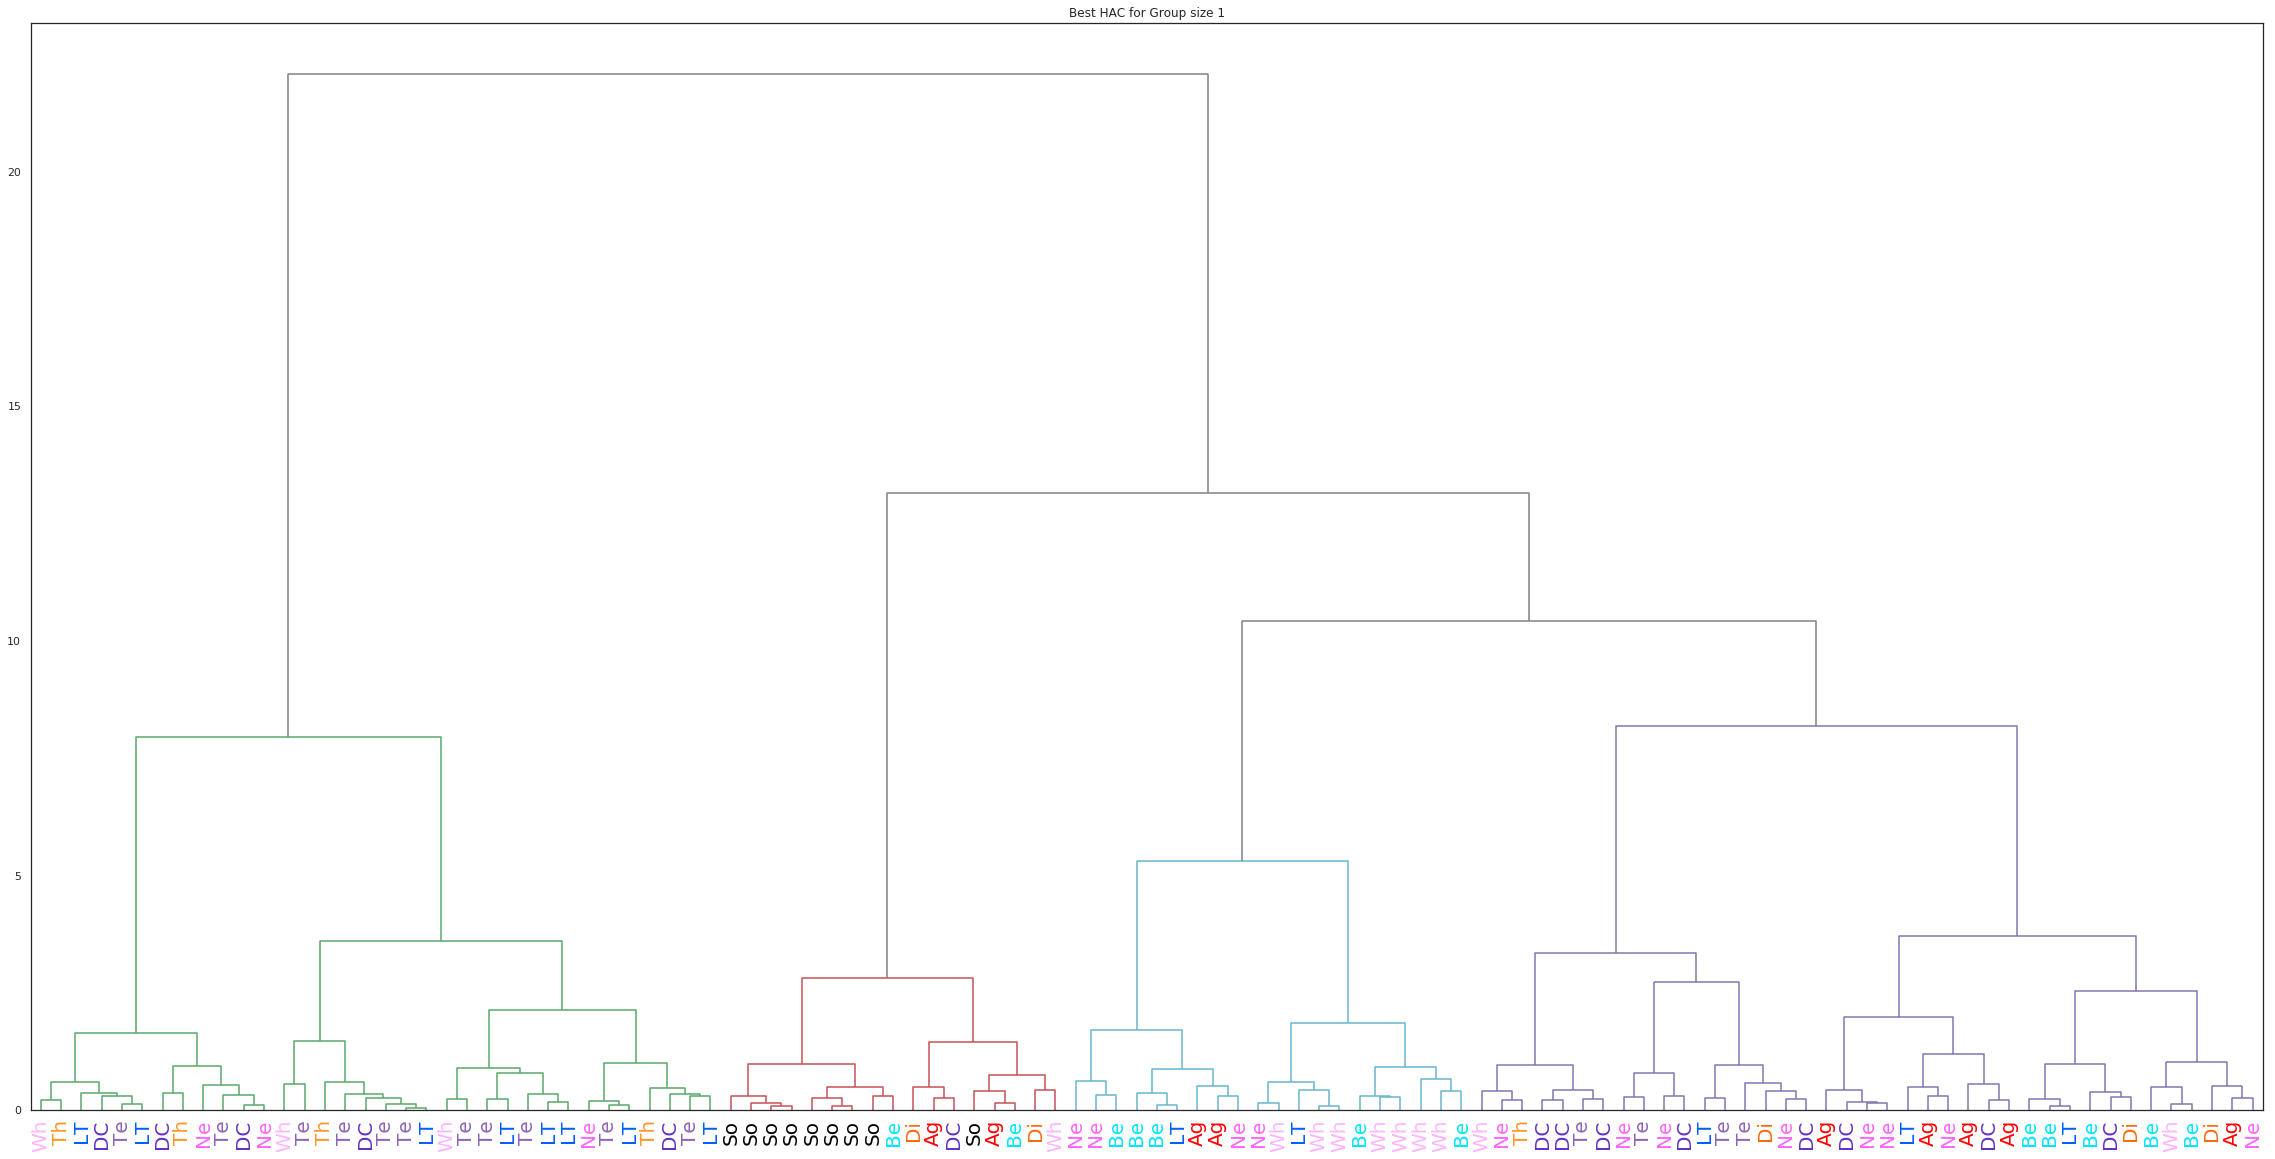

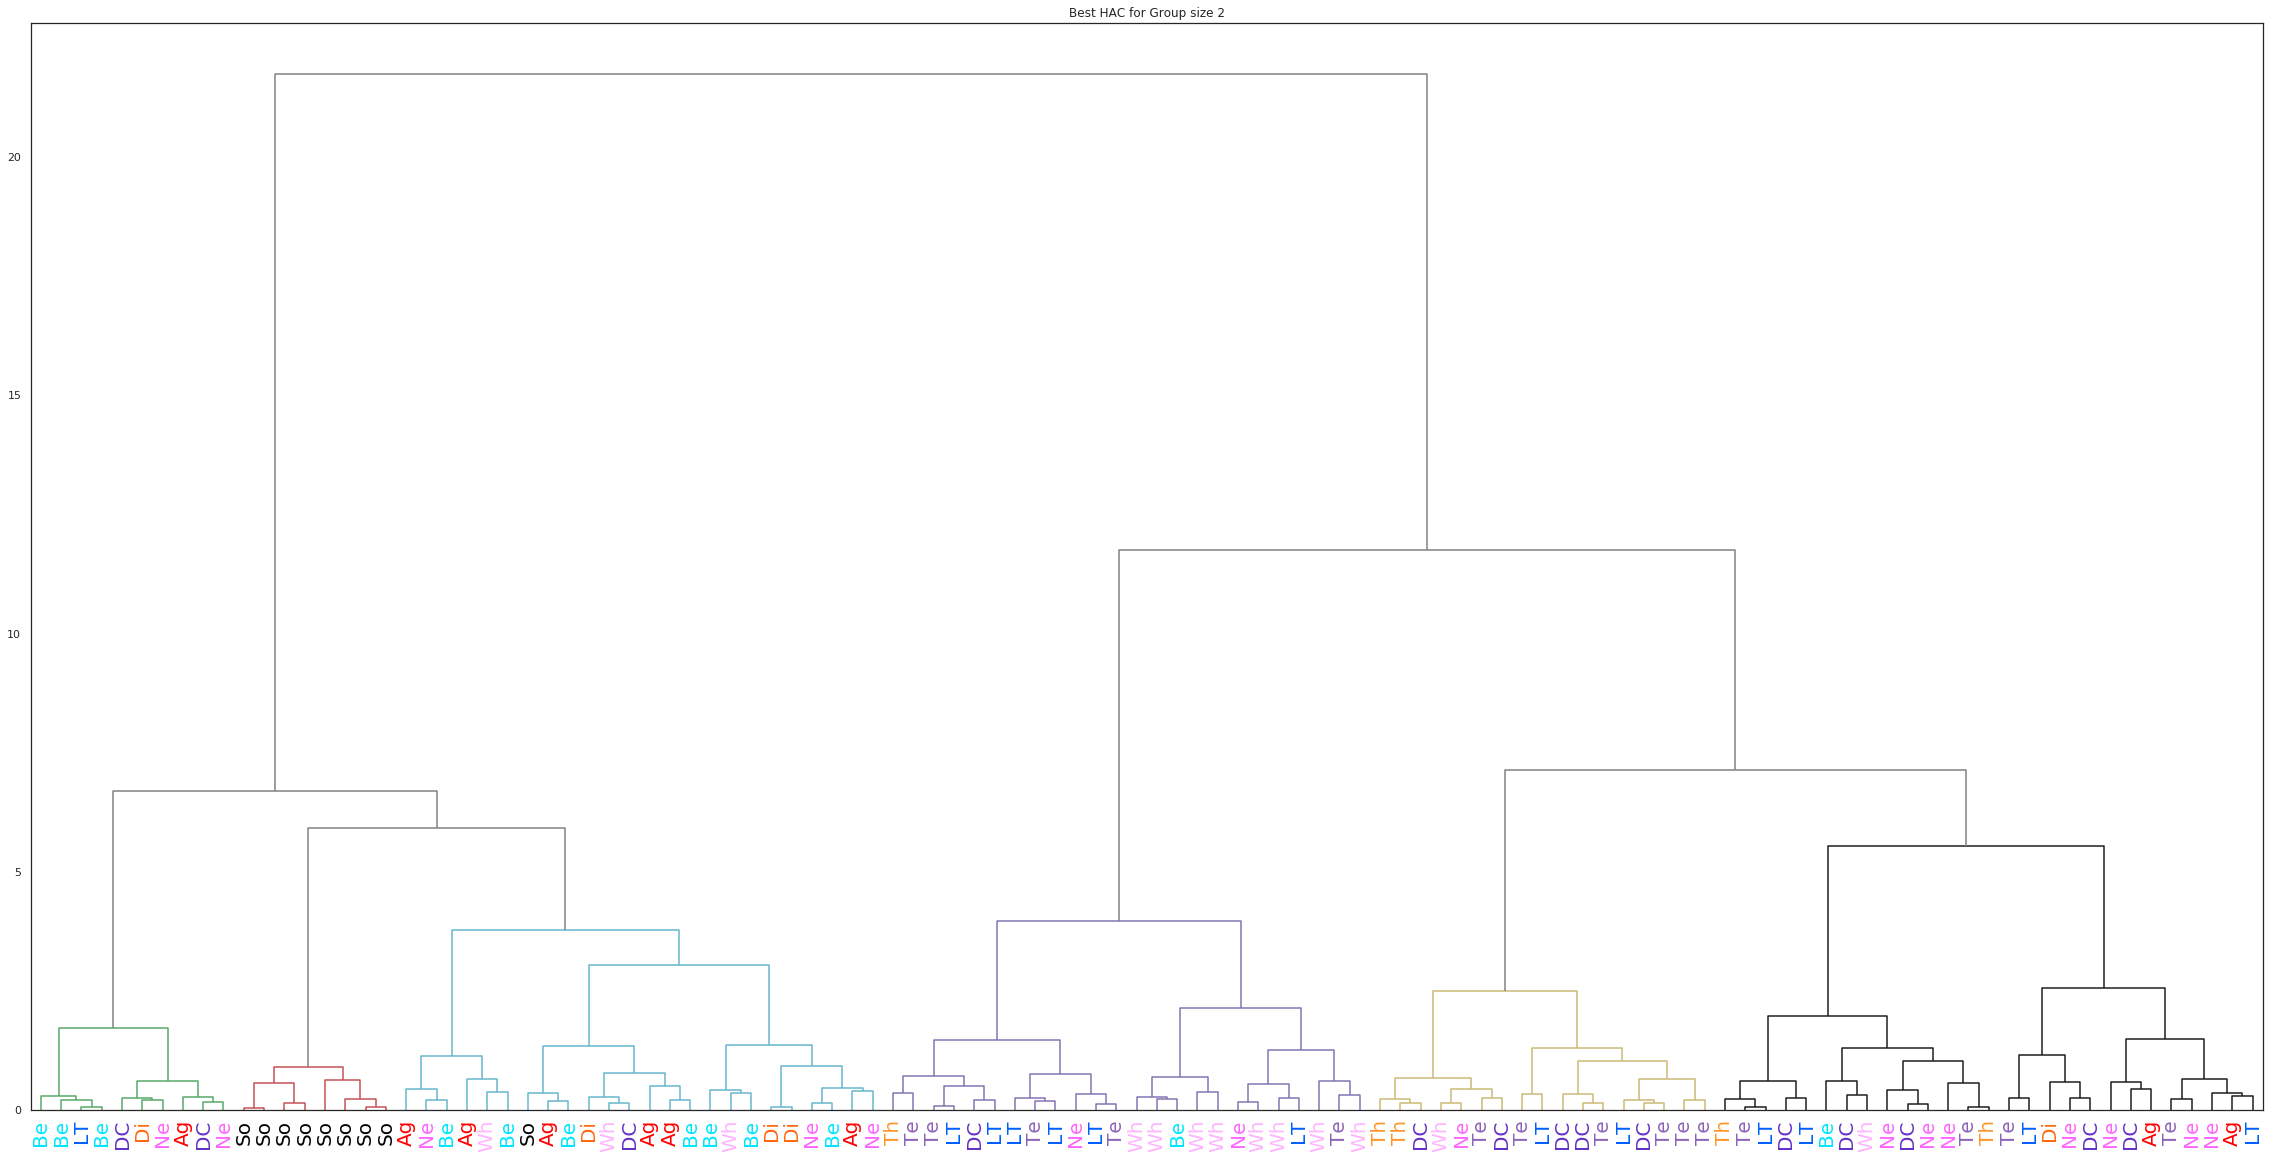

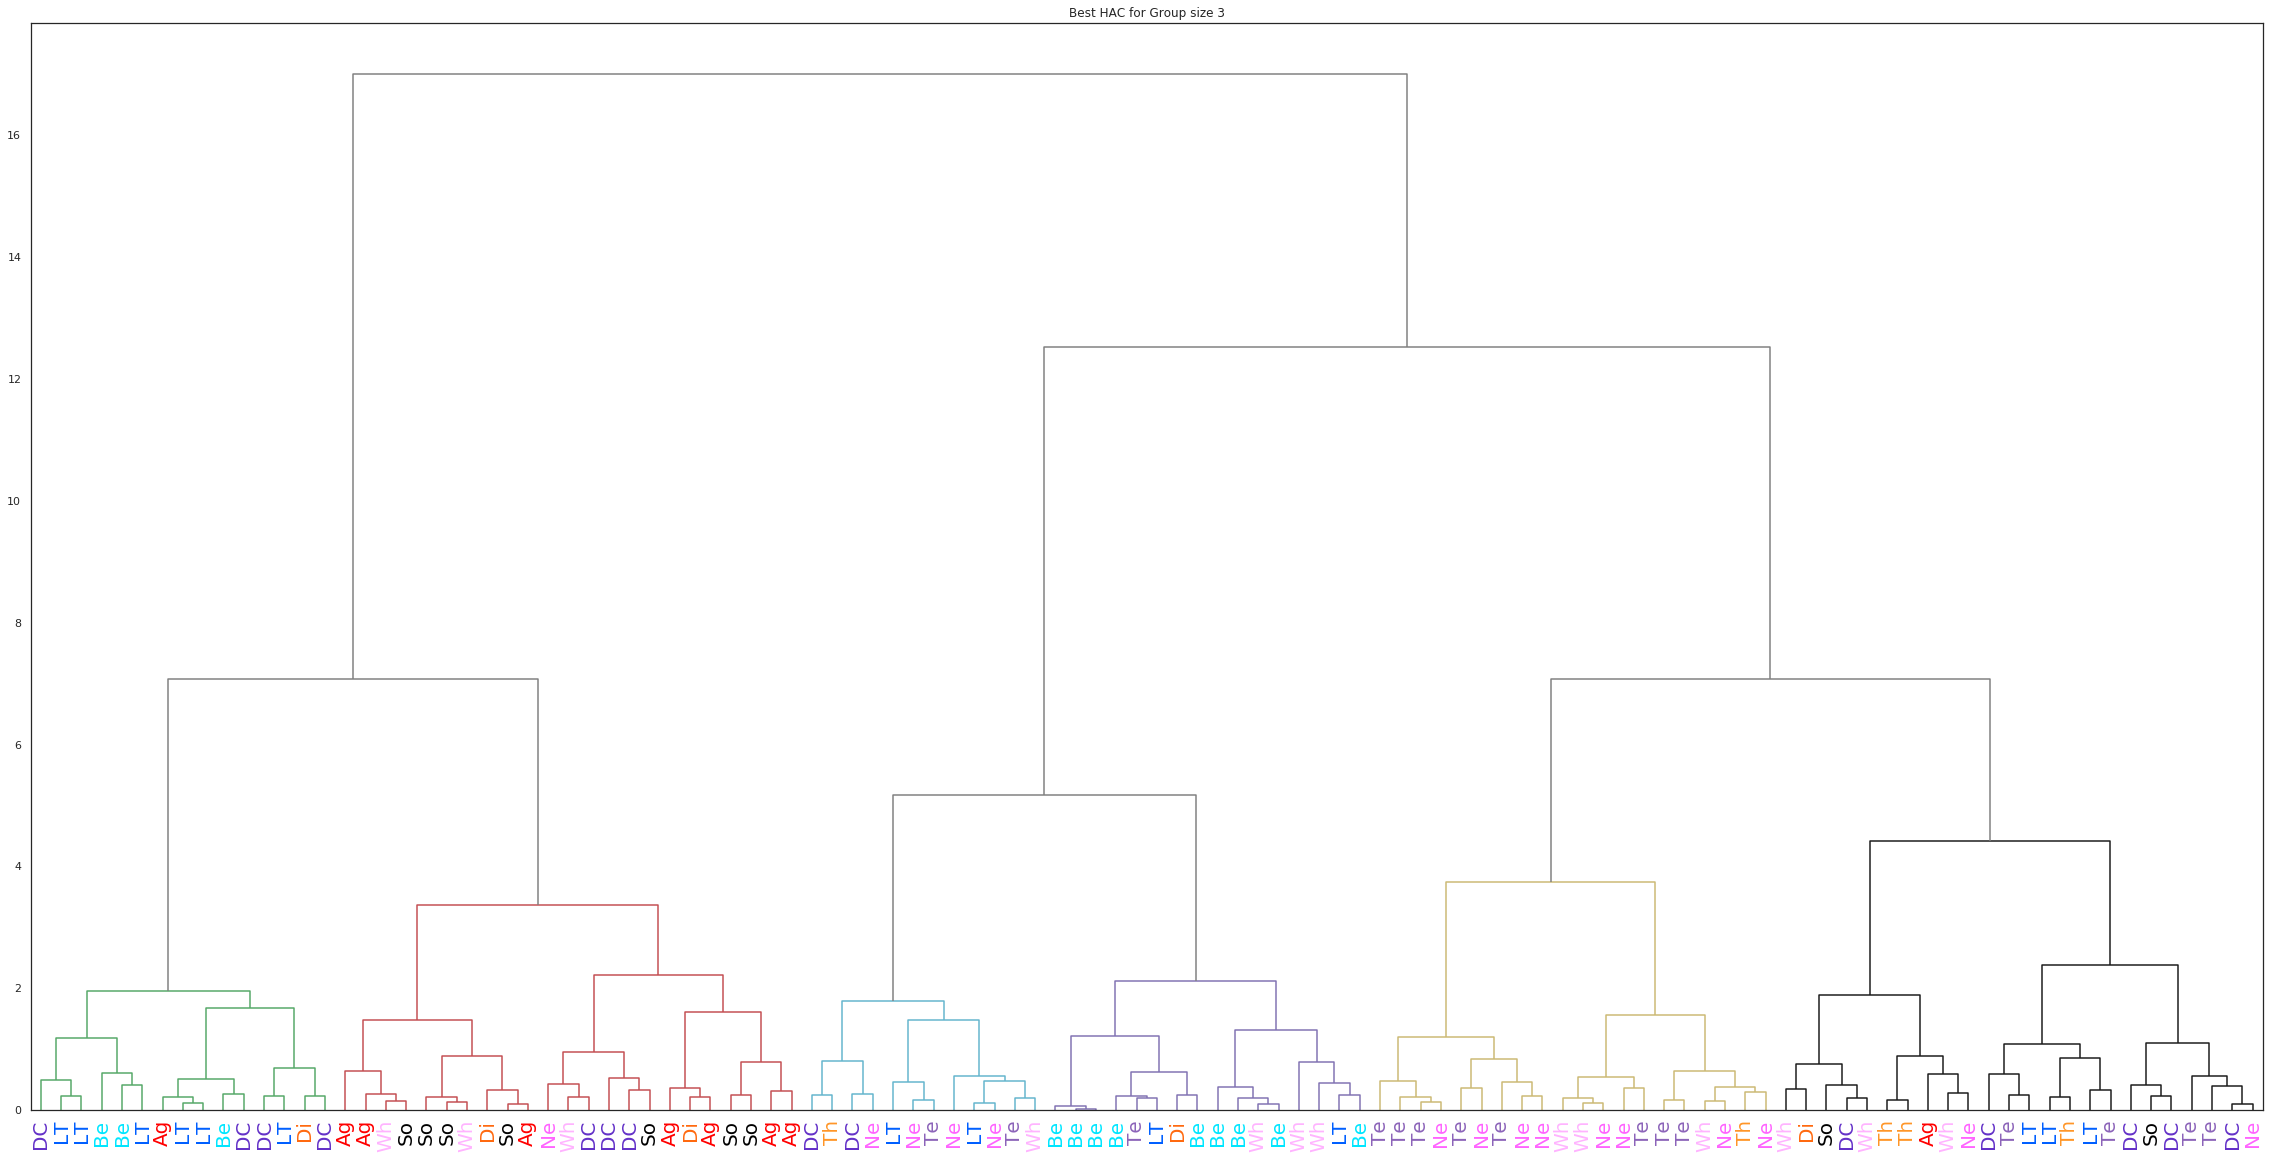

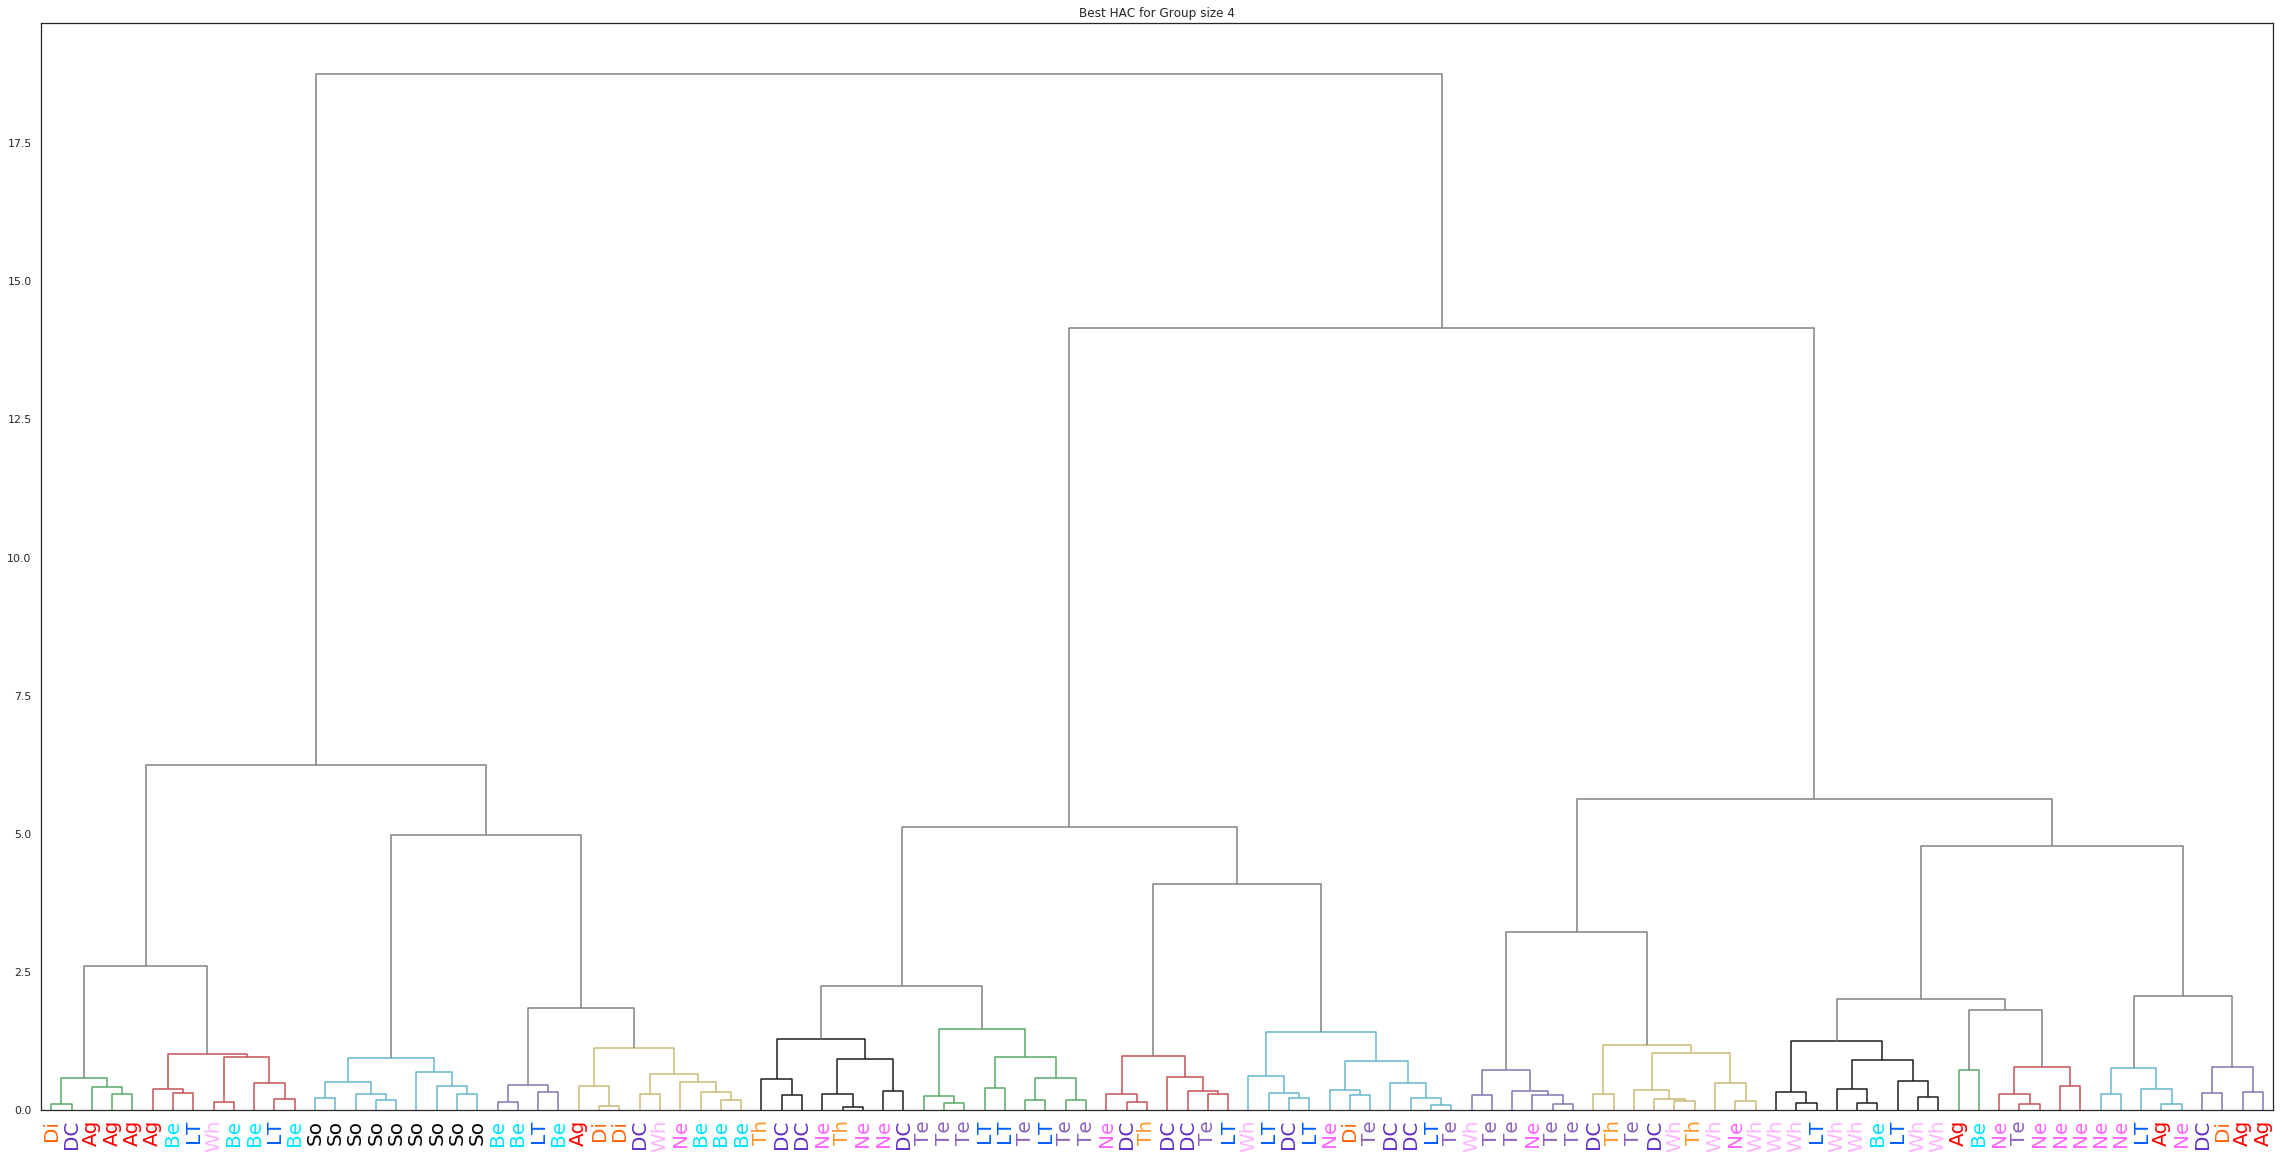

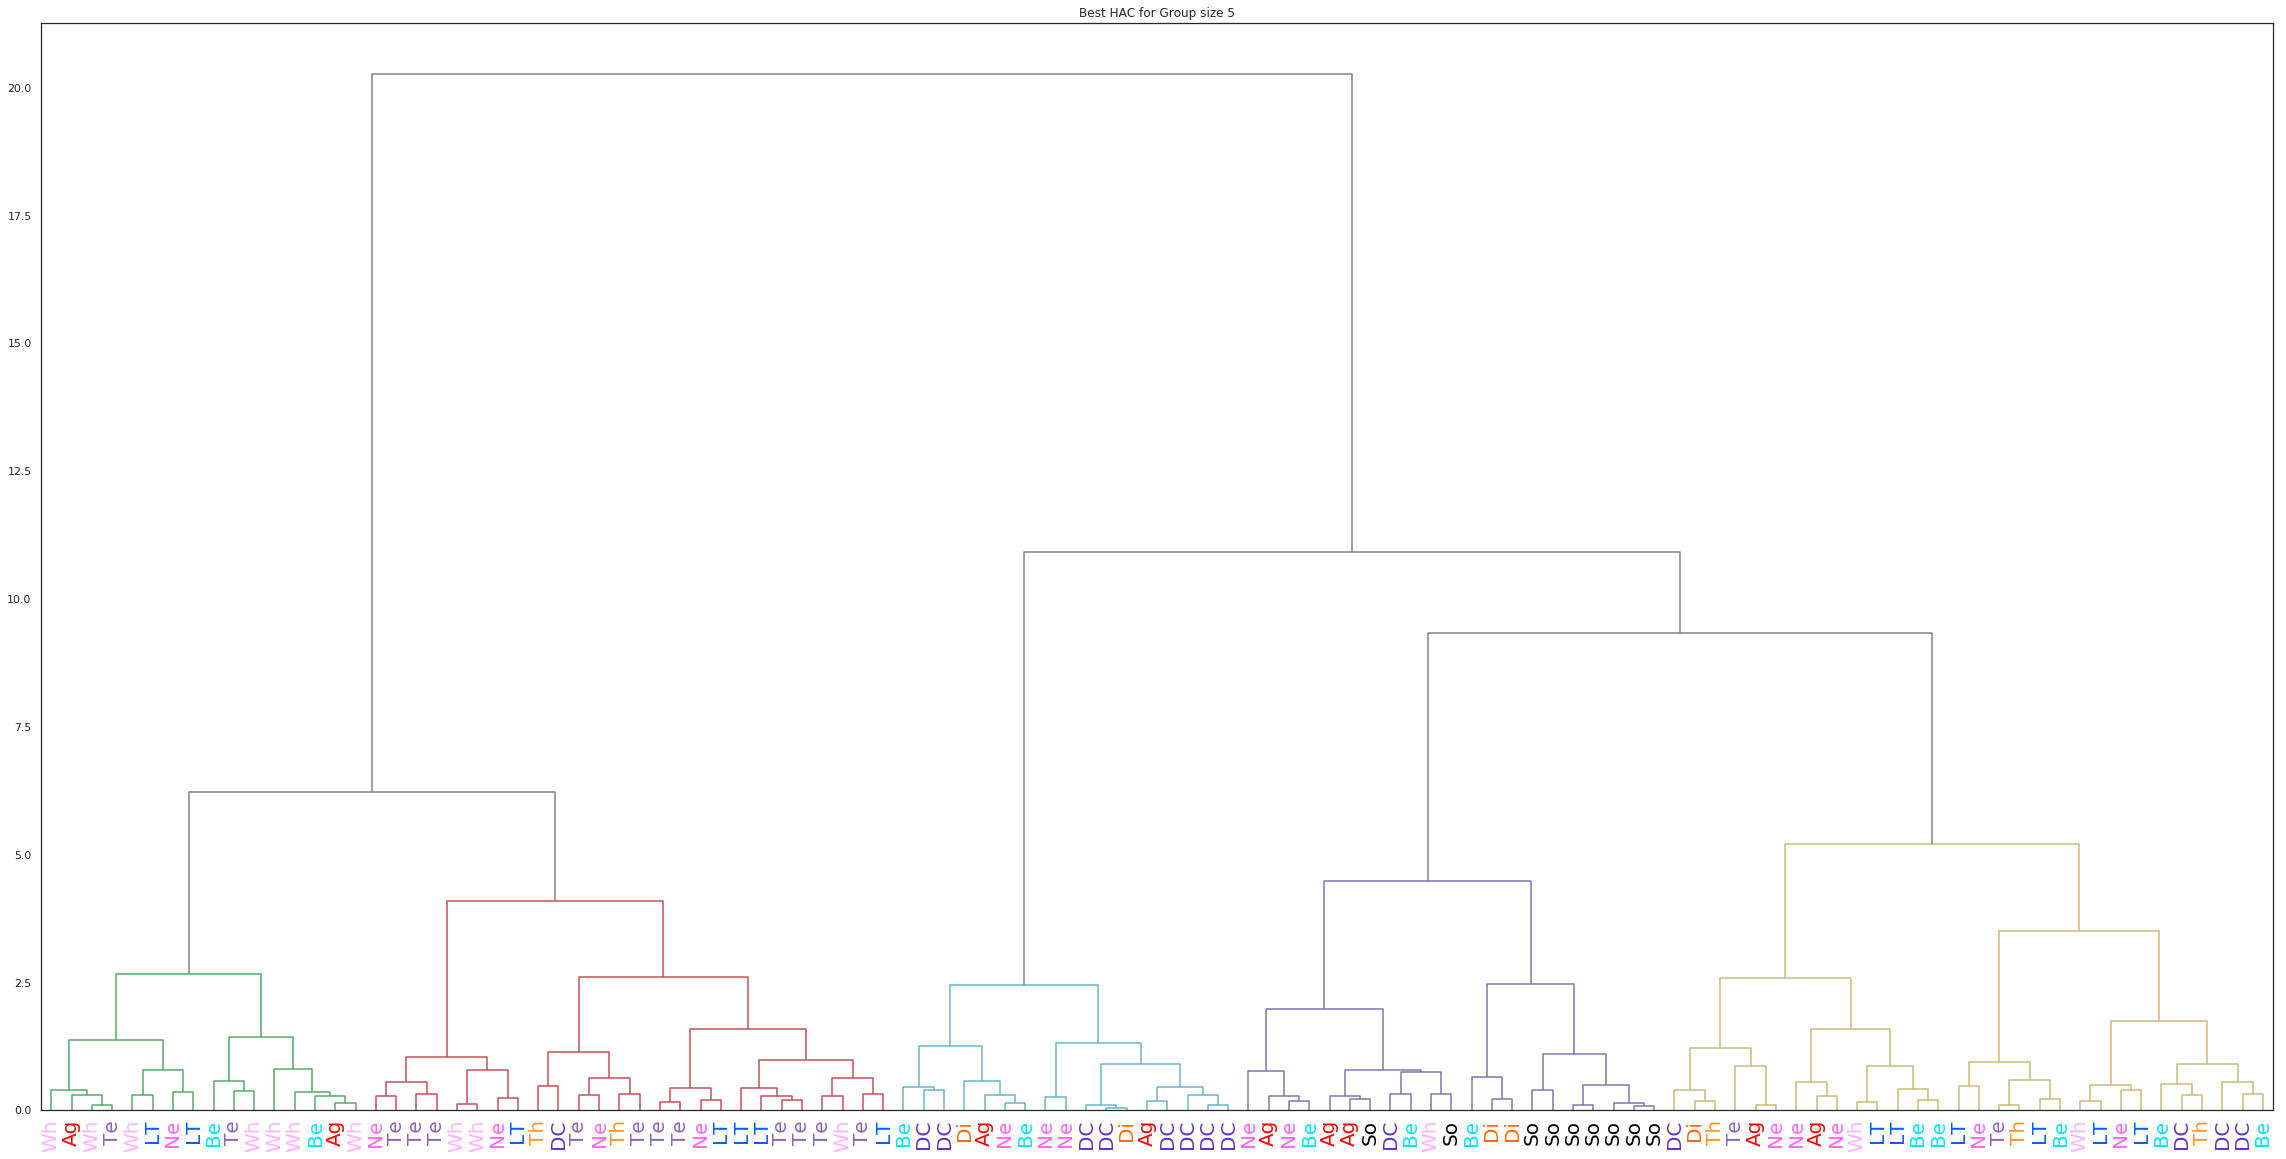

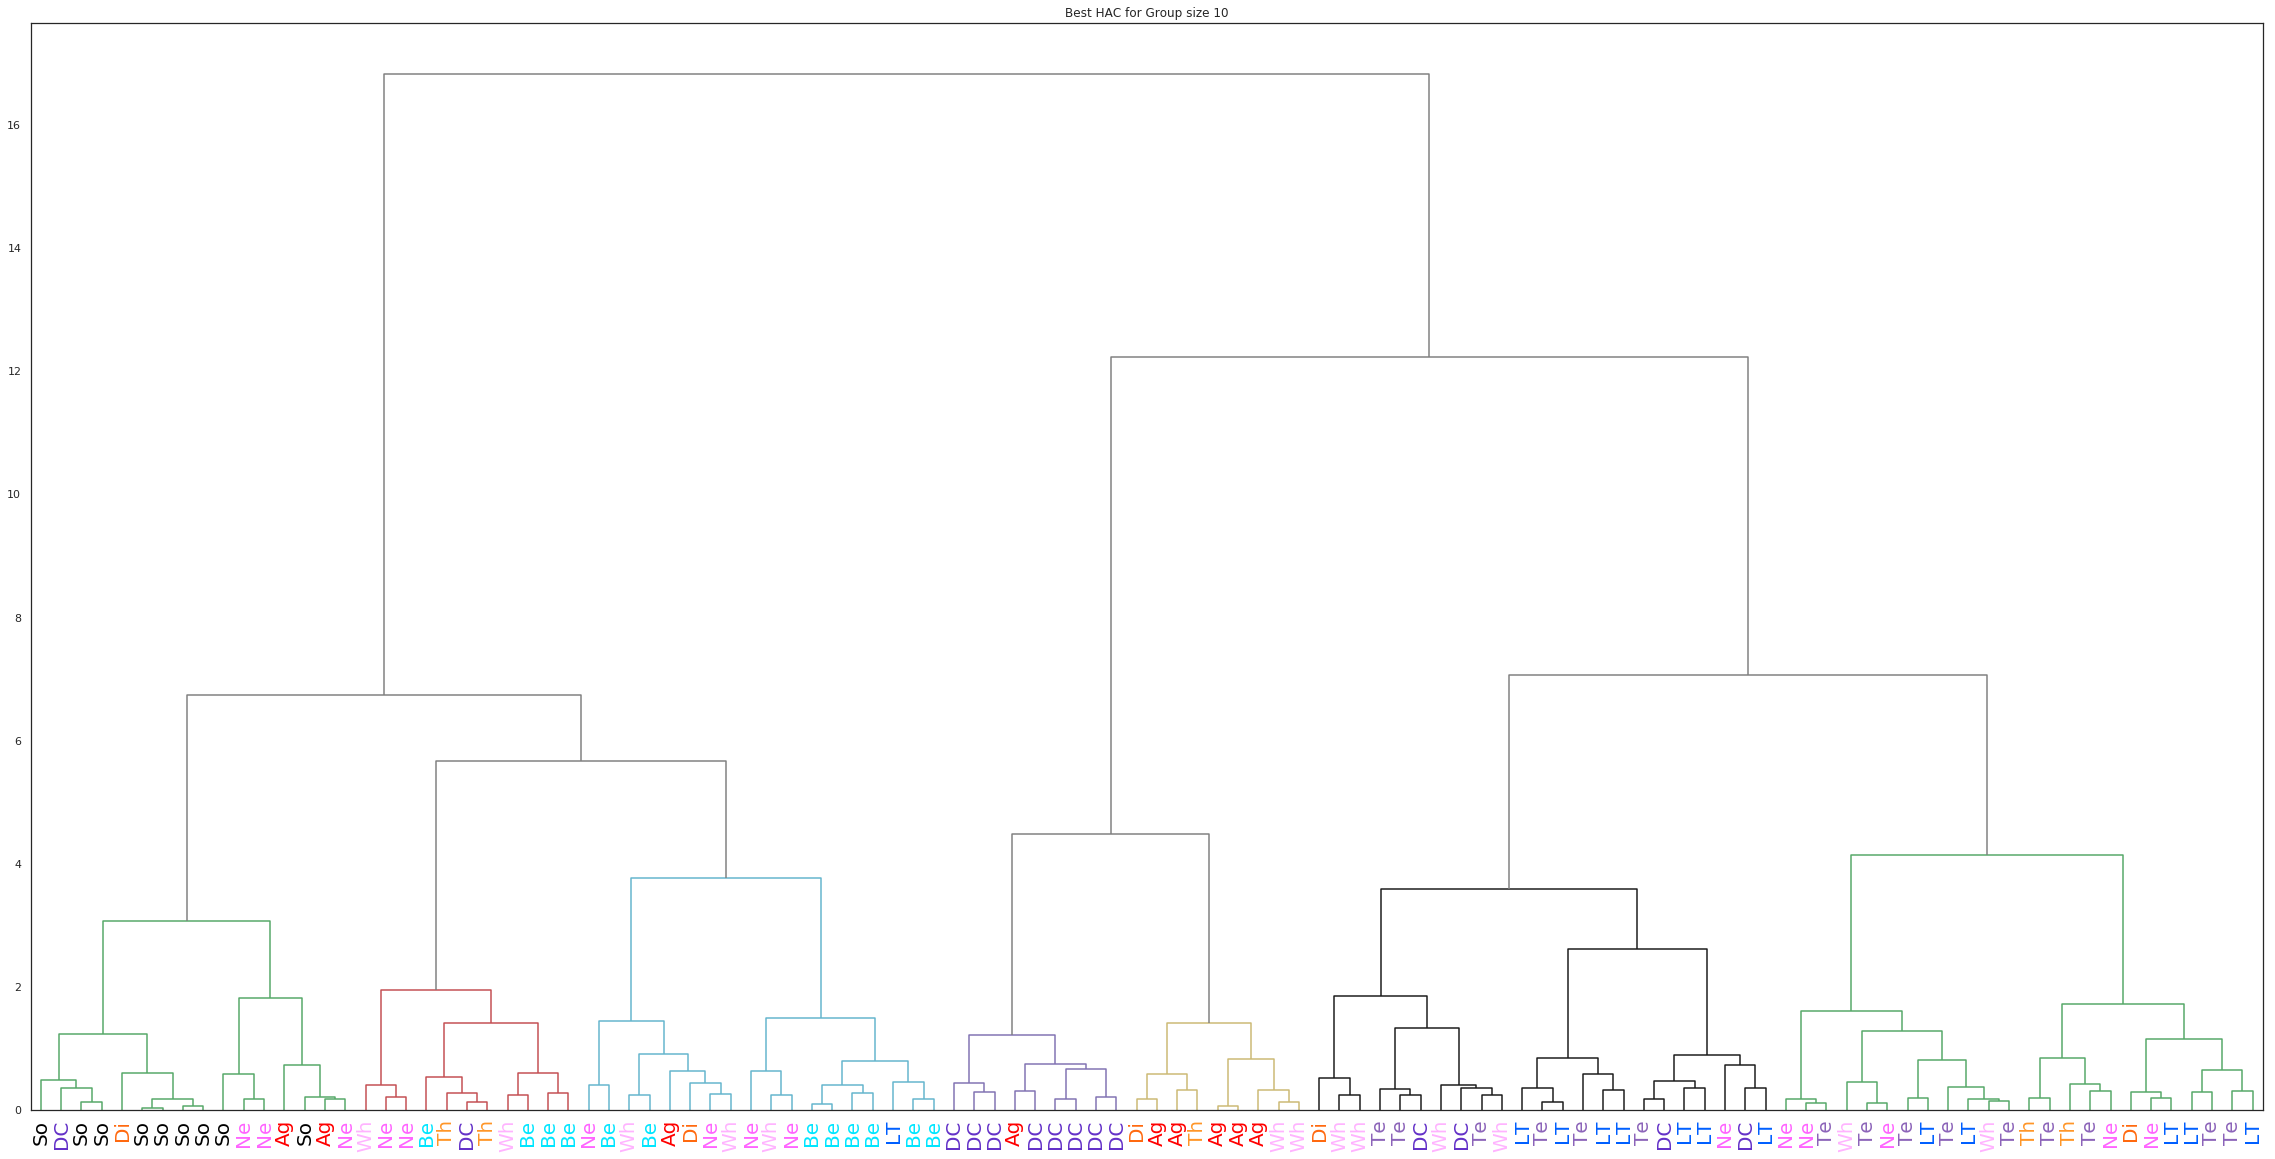

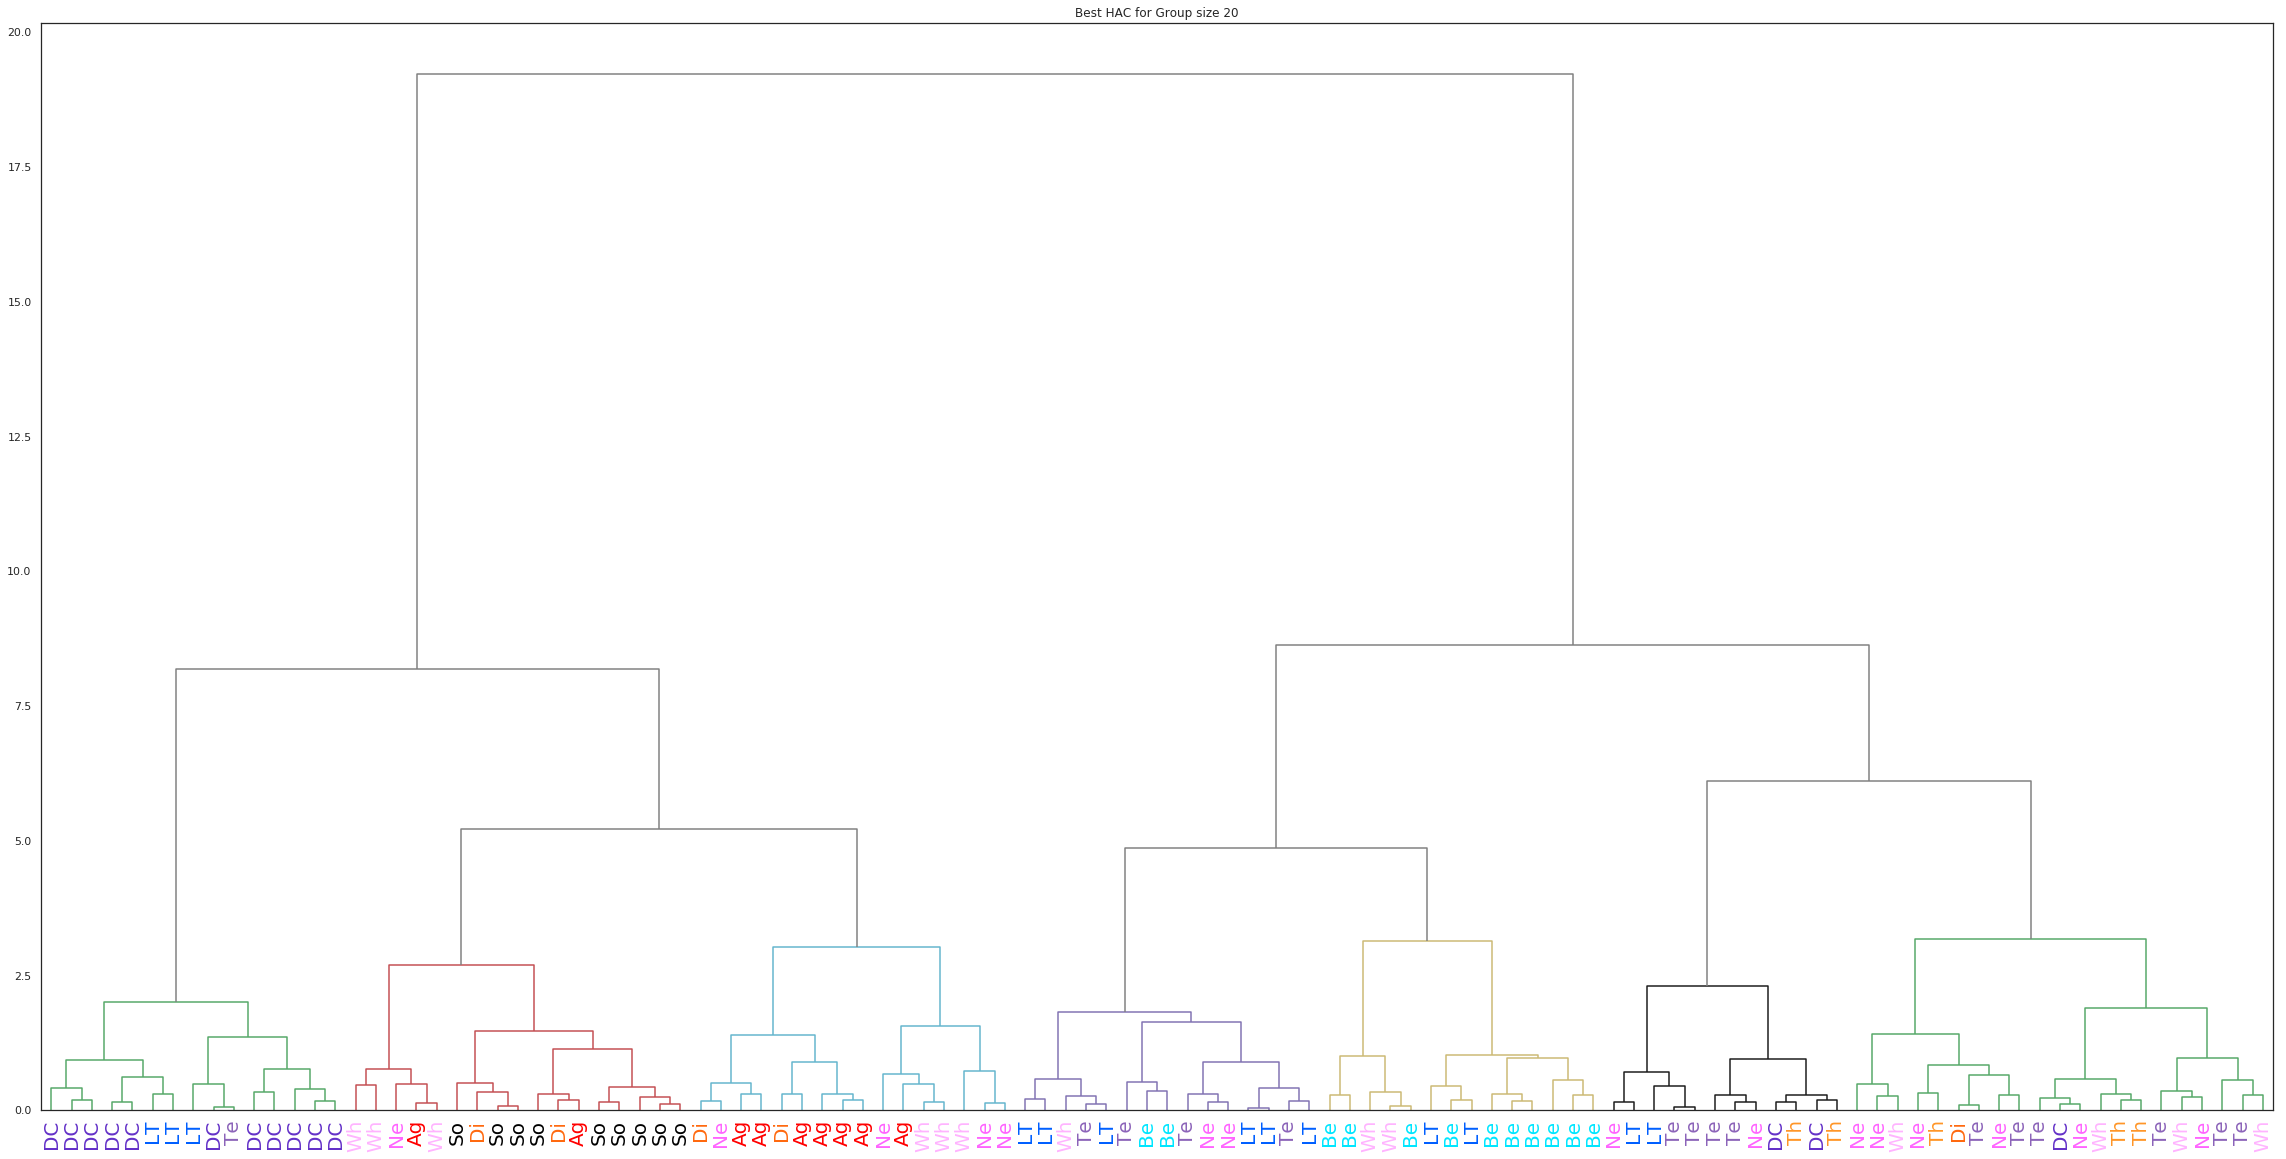

In [43]:
# for an example case we will use max ari index
for gs in np.unique(grp_size):
    aritmp = aris.copy()
    aritmp[grp_size != gs ] = 0
    max_ari_ind = np.argmax(aritmp)
    clustered=linkage(results[max_ari_ind][0][2],method ='ward')
    plt.figure(figsize= (40,20))
    D = dendrogram(Z=clustered, leaf_rotation=90.,
         leaf_font_size=20., # determine number by plotting cluster colors on leaves first
         labels= results[max_ari_ind][1], #finesem_calls[1:7633],
         #labels=np.array(labels), #voc_types,#plottinglabels,
         color_threshold= results[max_ari_ind][0][-1],
         above_threshold_color='grey')
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    for t in xlbls:
        t.set_color(callColor.get(t.get_text(),(0,0,0)))
    plt.title("Best HAC for Group size %s"%gs)

In [40]:
np.where(grp_size==1)[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

## Compare clustering to acoustic clustering with same calls

In [58]:
from scipy.stats.mstats import zscore


In [59]:
#path to the acoustical_analysis folder
#acoustic_dir = '/auto/fhome/lthomas/Google_Drive/Theunissen Rotation/acoustical_analysis_2'
#outdir = os.path.join(acoustic_dir,'testout')

#the fullVocal Paramater Bank motherload
fileRawData = '/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable.h5'
#fileRawData = os.path.join(acoustic_dir,'vocParamTable_FullVocBank.h5')
vocSelTable = pd.read_hdf(fileRawData)
# The features - indexing features out of the vocSelTable -- features created by soundsig previously
#These will be the features used to create linkages between the calls in the stimuli set or full bank

vocSelTable = vocSelTable[vocSelTable['samplerate'] != 0]

#These will be dimension len(numberofcallsinthedataset) by len(numberoffeatures contatenated)
XfundNames = np.hstack(('sal', 'fund','maxfund','minfund','cvfund')) #concatenating said features as labels of columns
Xfund = [vocSelTable.loc[:,col] for col in XfundNames ]
Xfund = np.stack(Xfund, axis=1) #only contains something like headers

XspectNames = np.hstack(('meanS', 'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3'))
Xspect = [vocSelTable.loc[:,col] for col in XspectNames ]
Xspect = np.stack(Xspect, axis=1)#only contains something like headers

XtempNames = np.hstack(('meanT', 'stdT', 'skewT', 'kurtT', 'entT'))
Xtemp = [vocSelTable.loc[:,col] for col in XtempNames ]
Xtemp = np.stack(Xtemp, axis=1)#only contains something like headers

XintensityNames = np.array(('rms', 'maxAmp'))
Xintensity = [vocSelTable.loc[:,col] for col in XintensityNames ]
Xintensity = np.stack(Xintensity, axis=1)#only contains something like headers

Xall = np.hstack((Xfund, Xspect, Xtemp, Xintensity))
XallNames = np.hstack((XfundNames, XspectNames, XtempNames, XintensityNames))
#np.save(os.path.join(outdir, 'feature_names_all7943'), XallNames)

# Z score all data that is not nan and make corresponding arrays for bird id and call type
nonanInd = (np.sum(np.isnan(Xall), axis = 1) == 0)
Xfundz = zscore(Xfund[nonanInd], axis=0)
Xspectz = zscore(Xspect[nonanInd], axis=0)
Xtempz = zscore(Xtemp[nonanInd], axis=0)
Xintensityz = zscore(Xintensity[nonanInd], axis=0)
Xallz = zscore(Xall[nonanInd], axis=0)

#this contains all the usable call types from vocSelTable
fine_semantic = np.array(vocSelTable['calltype'])[nonanInd] #previously vocSelTableGroupedAgg


fine_semantic[fine_semantic == '-A'] = 'Ag'



In [60]:
# because the stims are made up of multiple stims, We have to get the stim seg table
pdsegTable = pd.read_hdf("../data/ephys/StimSegTable.h5",'stim_seg')
pdsegTable.head()

,end,ind,start,stimend,stimname,stimstart,wav
0,0.343968,128,0.000023,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
1,0.451814,130,0.416168,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
2,0.601995,131,0.479410,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
3,1.273515,135,0.923537,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
4,0.538639,133,0.505850,0.627982,BlaBla0506_MAF_Ag_1,0.0,BlaBla0506_110304-AggC-09


In [47]:
len(pdsegTable)

1496

In [61]:
# get xallz for stims in the order that was used
stims = np.unique(dbHermina.stim)
has_wavs = np.zeros(len(stims),dtype=np.bool)
lbls = []
xallz_inds = []
for si, stim in enumerate(stims):
    # remove _fs25k.wav
    stim = stim[:-10]
    wavs = pdsegTable[pdsegTable.stimname==stim].sort_values('start')
    if len(wavs):
        first_wav = wavs.iloc[0]
        has_wavs[si] = 1
        #aud_row = acoustic_clustering[acoustic_clustering.filenames == first_wav.wav].iloc[0]
        xallz_inds.append(first_wav.ind)
        lbls.append(vocSelTable.loc[first_wav.ind].calltype)
        #lbls.append(aud_row.calltype)
    else:
        has_wavs[si] = 0
        print("Stim: %s \t Wav: None"%stim)
aud_vocsel = vocSelTable.loc[xallz_inds]

Stim: BlaLbl8026_FAS_Wh_1-8-6 	 Wav: None
Stim: BlaLbl8026_FAS_Wh_4-7-3 	 Wav: None
Stim: BlaLbl8026_FAS_Wh_5-9-2 	 Wav: None
Stim: GraLbl0457_MAS_Di_0 	 Wav: None
Stim: GraLbl0457_MAS_Di_1 	 Wav: None
Stim: GraLbl0457_MAS_Ne_3-6-7 	 Wav: None
Stim: GraLbl0457_MAS_Wh_4-9-1 	 Wav: None
Stim: GraLbl0457_MAS_Wh_5-2-8 	 Wav: None
Stim: GraLbl0457_MAS_Wh_6-7-3 	 Wav: None
Stim: LblGre0001_UCF_Be_0 	 Wav: None
Stim: WhiWhi1415_FAF_Ne_1-3-8 	 Wav: None
Stim: WhiWhi1415_FAF_Ne_2-6-5 	 Wav: None


In [49]:
aud_vocsel.head()

,Bird,F1,F2,F3,calltype,cvfund,duration,entS,entT,filename,...,q1,q2,q3,rms,sal,samplerate,skewS,skewT,stdS,stdT
128,BlaBla0506,1199.045499,3415.068967,5295.357596,Ag,0.196482,1.473197,0.858902,0.985814,BlaBla0506_110304-AggC-07,...,1076.660156,2325.585938,4177.441406,0.011966,0.345752,44100,1.134279,0.108395,2215.955546,0.089017
137,BlaBla0506,1274.170096,3405.049593,5429.640953,Ag,0.409956,0.627982,0.825820,0.961828,BlaBla0506_110304-AggC-09,...,1378.125000,1851.855469,3057.714844,0.012103,0.376355,44100,2.159852,0.256984,2106.990465,0.072154
137,BlaBla0506,1274.170096,3405.049593,5429.640953,Ag,0.409956,0.627982,0.825820,0.961828,BlaBla0506_110304-AggC-09,...,1378.125000,1851.855469,3057.714844,0.012103,0.376355,44100,2.159852,0.256984,2106.990465,0.072154
48,BlaBla0506,2038.889894,3457.578120,5074.733233,DC,0.013285,0.250816,0.701213,0.822217,BlaBla0506_110302-DC-11,...,1894.921875,2756.250000,3229.980469,0.040930,0.611889,44100,0.338754,0.205286,1036.388906,0.026926
50,BlaBla0506,2193.321303,3737.602607,5388.869055,DC,0.179770,0.255533,0.746753,0.822671,BlaBla0506_110302-DC-12,...,2024.121094,2885.449219,3832.910156,0.062724,0.556718,44100,0.802514,0.189521,1131.415031,0.027490


In [50]:
#These will be dimension len(numberofcallsinthedataset) by len(numberoffeatures contatenated)
XfundNames = np.hstack(('sal', 'fund','maxfund','minfund','cvfund')) #concatenating said features as labels of columns
Xfund = [aud_vocsel.loc[:,col] for col in XfundNames ]
Xfund = np.stack(Xfund, axis=1) #only contains something like headers

XspectNames = np.hstack(('meanS', 'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3'))
Xspect = [aud_vocsel.loc[:,col] for col in XspectNames ]
Xspect = np.stack(Xspect, axis=1)#only contains something like headers

XtempNames = np.hstack(('meanT', 'stdT', 'skewT', 'kurtT', 'entT'))
Xtemp = [aud_vocsel.loc[:,col] for col in XtempNames ]
Xtemp = np.stack(Xtemp, axis=1)#only contains something like headers

XintensityNames = np.array(('rms', 'maxAmp'))
Xintensity = [aud_vocsel.loc[:,col] for col in XintensityNames ]
Xintensity = np.stack(Xintensity, axis=1)#only contains something like headers

Xall = np.hstack((Xfund, Xspect, Xtemp, Xintensity))
XallNames = np.hstack((XfundNames, XspectNames, XtempNames, XintensityNames))
#np.save(os.path.join(outdir, 'feature_names_all7943'), XallNames)

# Z score all data that is not nan and make corresponding arrays for bird id and call type
nonanInd = (np.sum(np.isnan(Xall), axis = 1) == 0)
Xfundz = zscore(Xfund[nonanInd], axis=0)
Xspectz = zscore(Xspect[nonanInd], axis=0)
Xtempz = zscore(Xtemp[nonanInd], axis=0)
Xintensityz = zscore(Xintensity[nonanInd], axis=0)
Xallz = zscore(Xall[nonanInd], axis=0)

#this contains all the usable call types from vocSelTable
fine_semantic = np.array(aud_vocsel['calltype'])[nonanInd] #previously vocSelTableGroupedAgg


fine_semantic[fine_semantic == '-A'] = 'Ag'



In [245]:
plt.imshow

In [247]:
best_grouping

array([4, 4, 4, ..., 3, 2, 2], dtype=int32)

-------------
ARI: 0.3674180750911364


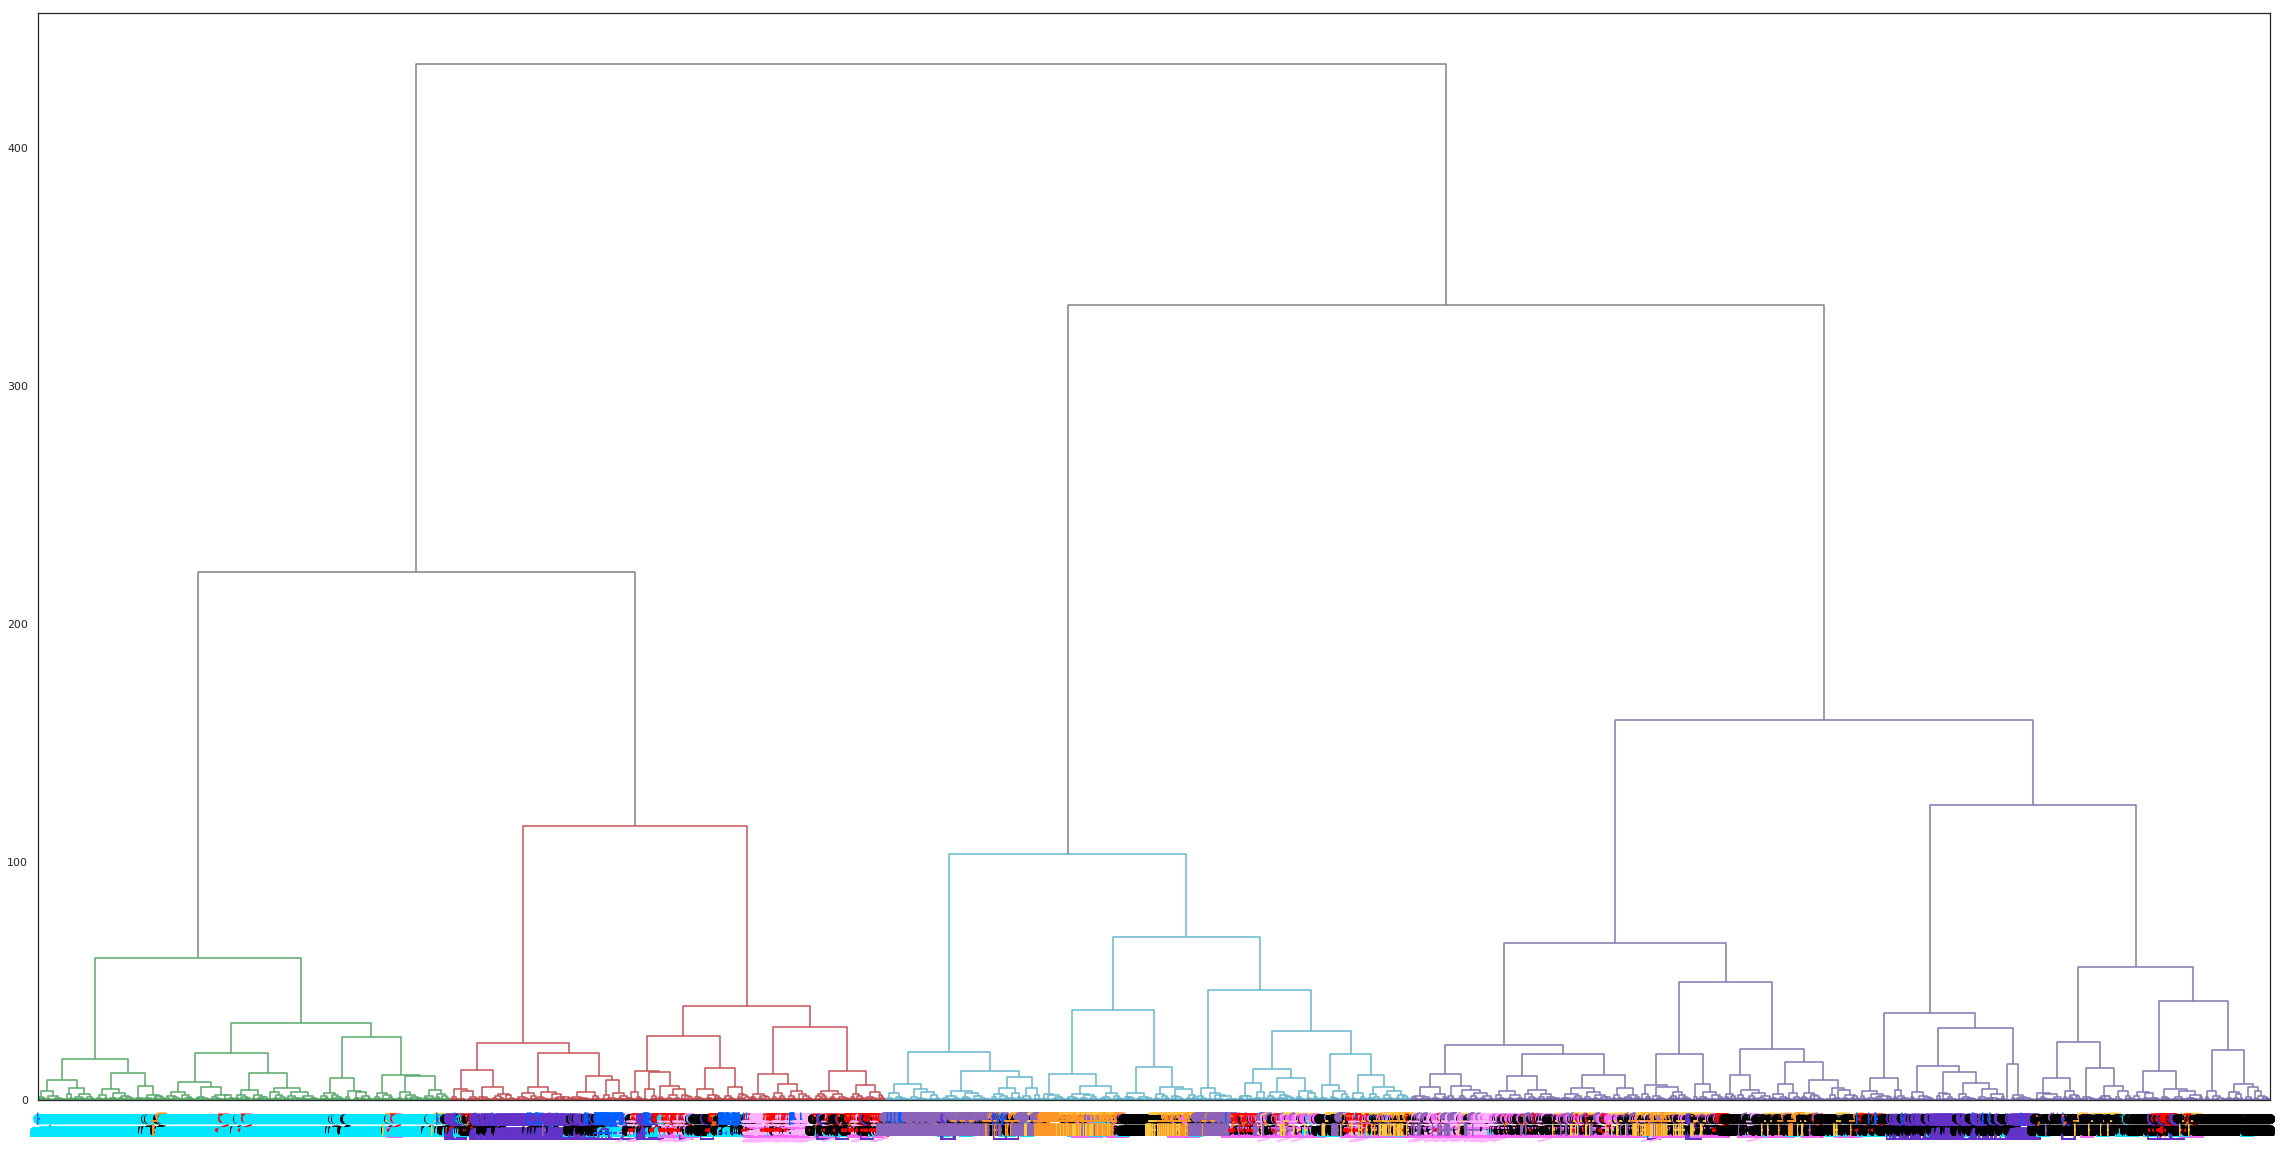

In [235]:
F,max_ari, MesPCS, unique_groupings, best_grouping = cluster_functions.cluster_analysis(Xallz,np.squeeze(fine_semantic),and_plot=True,use_umap=True)

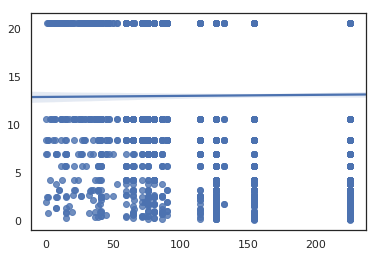

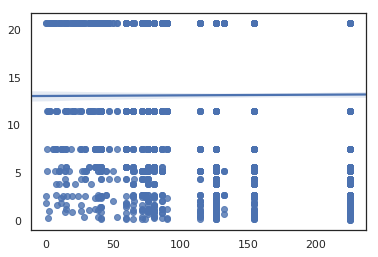

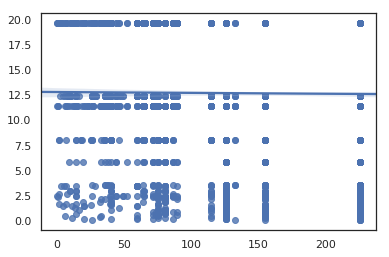

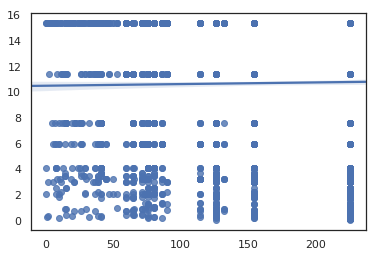

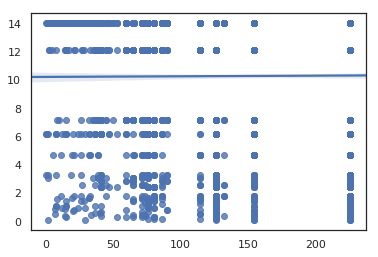

In [88]:
# this experimentally compares cop distance on the big dendrogram vs cop distance on the small dendrogram
from scipy.spatial.distance import pdist, squareform


aud_clust = linkage(Xallz,method='ward')
aud_cop = cophenet(aud_clust)

sq_cop = squareform(aud_cop)
new_rows = np.asarray(sq_cop[xallz_inds]).T
small_mat = np.asarray(new_rows[xallz_inds]).T
small_mat = squareform(small_mat)

max_ari_ind = np.argmax(aris)
for i in range(5):
    plt.figure()
    rand_ind = np.random.randint(0,len(aris))
    neu_clust = linkage(results[rand_ind][0][2][has_wavs],method='ward')
    neu_cop = cophenet(neu_clust)
    #plt.scatter(np.log10(aud_cop),np.log10(neu_cop))
    seaborn.regplot(small_mat,neu_cop)

In [218]:
aris[np.random.randint(0,len(aris))]

2778

In [52]:
acoustic_clustering[acoustic_clustering.filenames == "BlaLbl8026_110607-WhineC-06"].iloc[0].pca1

-1.145136243816548

## OR start from the vocparamtable clusters

In [30]:
# load acoustic umap
acoustic_clustering = pd.read_hdf('/auto/zdrive/lthomas/FullVocBank_2020/vocParamTable_clusters.h5','clusters')
acoustic_clustering.head(5)

,calltype,filenames,groups_pca,groups_umap,pca1,pca2,umap1,umap2
0,Wh,BlaLbl8026_110607-WhineC-05,4,5,-1.159463,-1.132881,-1.005874,1.209956
1,Wh,BlaLbl8026_110607-WhineC-04,3,5,-1.578668,-2.116606,0.817599,0.590500
2,Wh,BlaLbl8026_110607-WhineC-06,3,5,-1.145136,-1.717987,1.280105,0.239141
3,DC,BlaLbl8026_110429-DC-11,3,1,1.112016,0.707791,6.123713,-2.425279
4,Ne,GraLbl0457_110509-NestC-03,4,5,-2.375957,-0.451540,-0.131751,3.354254


In [31]:
# because the stims are made up of multiple stims, We have to get the stim seg table
pdsegTable = pd.read_hdf("../data/ephys/StimSegTable.h5",'stim_seg')
pdsegTable.head()

,end,ind,start,stimend,stimname,stimstart,wav
0,0.343968,128,0.000023,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
1,0.451814,130,0.416168,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
2,0.601995,131,0.479410,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
3,1.273515,135,0.923537,1.473197,BlaBla0506_MAF_Ag_0,0.0,BlaBla0506_110304-AggC-07
4,0.538639,133,0.505850,0.627982,BlaBla0506_MAF_Ag_1,0.0,BlaBla0506_110304-AggC-09


In [45]:
# get umaps for stims in the order that was used
stims = np.unique(dbHermina.stim)
has_wavs = np.zeros(len(stims),dtype=np.bool)
aud_pcs = []
aud_umaps = []
lbls = []
aud_lbl_pc = []
aud_lbl_umap = []
for si, stim in enumerate(stims):
    # remove _fs25k.wav
    stim = stim[:-10]
    wavs = pdsegTable[pdsegTable.stimname==stim].sort_values('start')
    if len(wavs):
        first_wav = wavs.iloc[0]
        has_wavs[si] = 1
        aud_row = acoustic_clustering[acoustic_clustering.filenames == first_wav.wav].iloc[0]
        lbls.append(aud_row.calltype)
        aud_lbl_pc.append(aud_row.groups_pca)
        aud_lbl_umap.append(aud_row.groups_umap)
        aud_pcs.append([aud_row.pca1, aud_row.pca2])
        aud_umaps.append([aud_row.umap1, aud_row.umap2])
    else:
        has_wavs[si] = 0
        print("Stim: %s \t Wav: None"%stim)
aud_pcs = np.asarray(aud_pcs)
aud_umaps = np.asarray(aud_umaps)

Stim: BlaLbl8026_FAS_Wh_1-8-6 	 Wav: None
Stim: BlaLbl8026_FAS_Wh_4-7-3 	 Wav: None
Stim: BlaLbl8026_FAS_Wh_5-9-2 	 Wav: None
Stim: GraLbl0457_MAS_Di_0 	 Wav: None
Stim: GraLbl0457_MAS_Di_1 	 Wav: None
Stim: GraLbl0457_MAS_Ne_3-6-7 	 Wav: None
Stim: GraLbl0457_MAS_Wh_4-9-1 	 Wav: None
Stim: GraLbl0457_MAS_Wh_5-2-8 	 Wav: None
Stim: GraLbl0457_MAS_Wh_6-7-3 	 Wav: None
Stim: LblGre0001_UCF_Be_0 	 Wav: None
Stim: WhiWhi1415_FAF_Ne_1-3-8 	 Wav: None
Stim: WhiWhi1415_FAF_Ne_2-6-5 	 Wav: None


In [70]:
#groups = glob.glob("../data/ephys_Germany/Groupings/Groupings_*.pkl")
# make a dataframe for easy processing
dfout_add = dict({
    'neural_grouping': [],
    'ari_neural_vs_aud': []})
for gi, group_fp in enumerate(groups):
#def proc_group_pf(group_fp):
    print("Starting %s"%group_fp)
    tst = time.time()
    group = pk.load(open(group_fp,'rb'))
    pccs = group['pccs']
    results = group['results']
    neural_groupings = [r[4] for r in results]
    
    n_v_a_aris = [ adjusted_rand_score(ng[has_wavs],aud_lbl_umap) if ng is not None else 0.0 for ng in neural_groupings]
    dfout_add['neural_grouping'].extend(neural_groupings)
    dfout_add['ari_neural_vs_aud'].extend(n_v_a_aris)
    print("Finished %s in %s"%(group_fp,time.time()-tst))
    #return results[0][4], adjusted_rand_score(results[0][4][has_wavs],aud_lbl_umap)



dfout_f['neural_grouping'] =  dfout_add['neural_grouping']# = pd.DataFrame(dfout)
dfout_f['ari_neural_vs_aud'] = dfout_add['ari_neural_vs_aud']#
dfout_f.to_hdf("../data/ephys_Germany/Groupings_metadata_with_ng.hdf",'')

Starting ../data/ephys_Germany/Groupings/Groupings_1.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_1.pkl in 0.05123138427734375
Starting ../data/ephys_Germany/Groupings/Groupings_2.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_2.pkl in 2.0456409454345703
Starting ../data/ephys_Germany/Groupings/Groupings_3.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_3.pkl in 4.103828430175781
Starting ../data/ephys_Germany/Groupings/Groupings_4.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_4.pkl in 4.081872224807739
Starting ../data/ephys_Germany/Groupings/Groupings_5.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_5.pkl in 4.08459997177124
Starting ../data/ephys_Germany/Groupings/Groupings_10.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_10.pkl in 4.10617470741272
Starting ../data/ephys_Germany/Groupings/Groupings_20.pkl
Finished ../data/ephys_Germany/Groupings/Groupings_20.pkl in 4.08282732963562


TypeError: to_hdf() missing 1 required positional argument: 'key'

In [27]:
dfout_f = pd.read_hdf("../data/ephys_Germany/Groupings_metadata_with_ng.hdf")

In [29]:
dfout_f.keys()

Index(['ari_calltype', 'group_size', 'pcc_bayes', 'neural_grouping',
       'ari_neural_vs_aud'],
      dtype='object')

In [80]:
## Helper to animate scatter plot interp
import matplotlib.animation as animation
def interp_scatter(a,b, out_fn,colo):

    def update_plot(t):
        interpolation = a*(1-t) + b*t
        #scat._offsets = interpolation.T
        scat.set_offsets( interpolation)
        scat._facecolor3d = [255, 0, 255, 255]
        ax.set_xlim(interpolation[:,0].min()-1,interpolation[:,0].max()+1)
        ax.set_ylim(interpolation[:,1].min()-2,interpolation[:,1].max()+2)
        return scat,

    fig = plt.figure(figsize=(10,6))
    ax = fig.gca()
    scat = ax.scatter(a[:, 0], a[:, 1], c=colo,s=10.0)
    #scat = ax.scatter([], [])
    ani = animation.FuncAnimation(fig, update_plot, frames=np.arange(0, 1, 0.01))
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=30, metadata=dict(artist='Me'))#, bitrate=1800)
    #ani.save('3d.gif', dpi=80, writer='imagemagick')
    ani.save(out_fn, writer=writer)


In [76]:
callColor['WC'] = (.80,.80,.80)

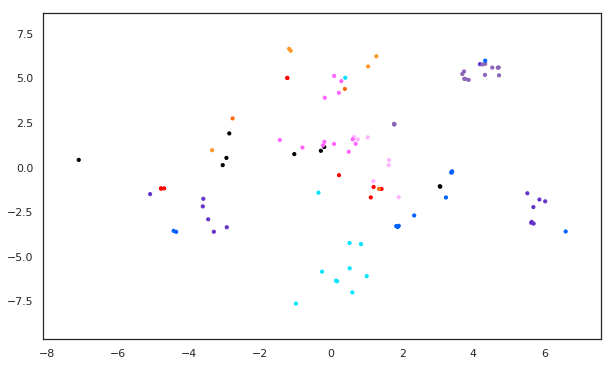

In [84]:
max_ari_ind = np.argmin(pccs_rand)
max_ari_comp_aud_ind = np.argmin(max_aris_comp_aud)
interp_scatter( results[max_ari_comp_aud_ind][0][2][has_wavs],aud_umaps, "Max_AMI_COMP_AUD.mp4",[callColor[x] for x in lbls])

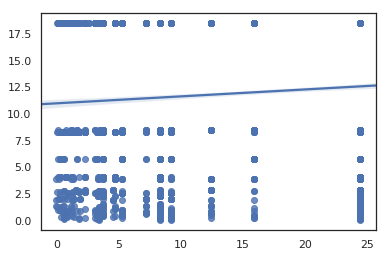

In [90]:
ind = np.random.randint(0,len(results))
aud_clust = linkage(aud_pcs,method='ward')
aud_cop = cophenet(aud_clust)
aud_uclust = linkage(aud_umaps,method='ward')
aud_ucop = cophenet(aud_uclust)
neu_clust = linkage(results[max_ari_ind][0][2][has_wavs],method='ward')
neu_cop = cophenet(neu_clust)
seaborn.regplot(aud_cop,neu_cop)

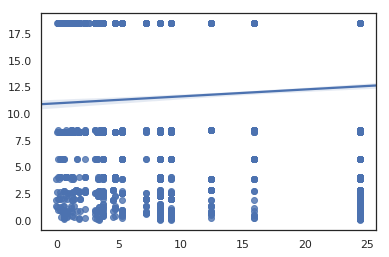

In [61]:
#plt.scatter(np.log10(aud_cop),np.log10(neu_cop))

-------------
ARI: 0.06406996514146435


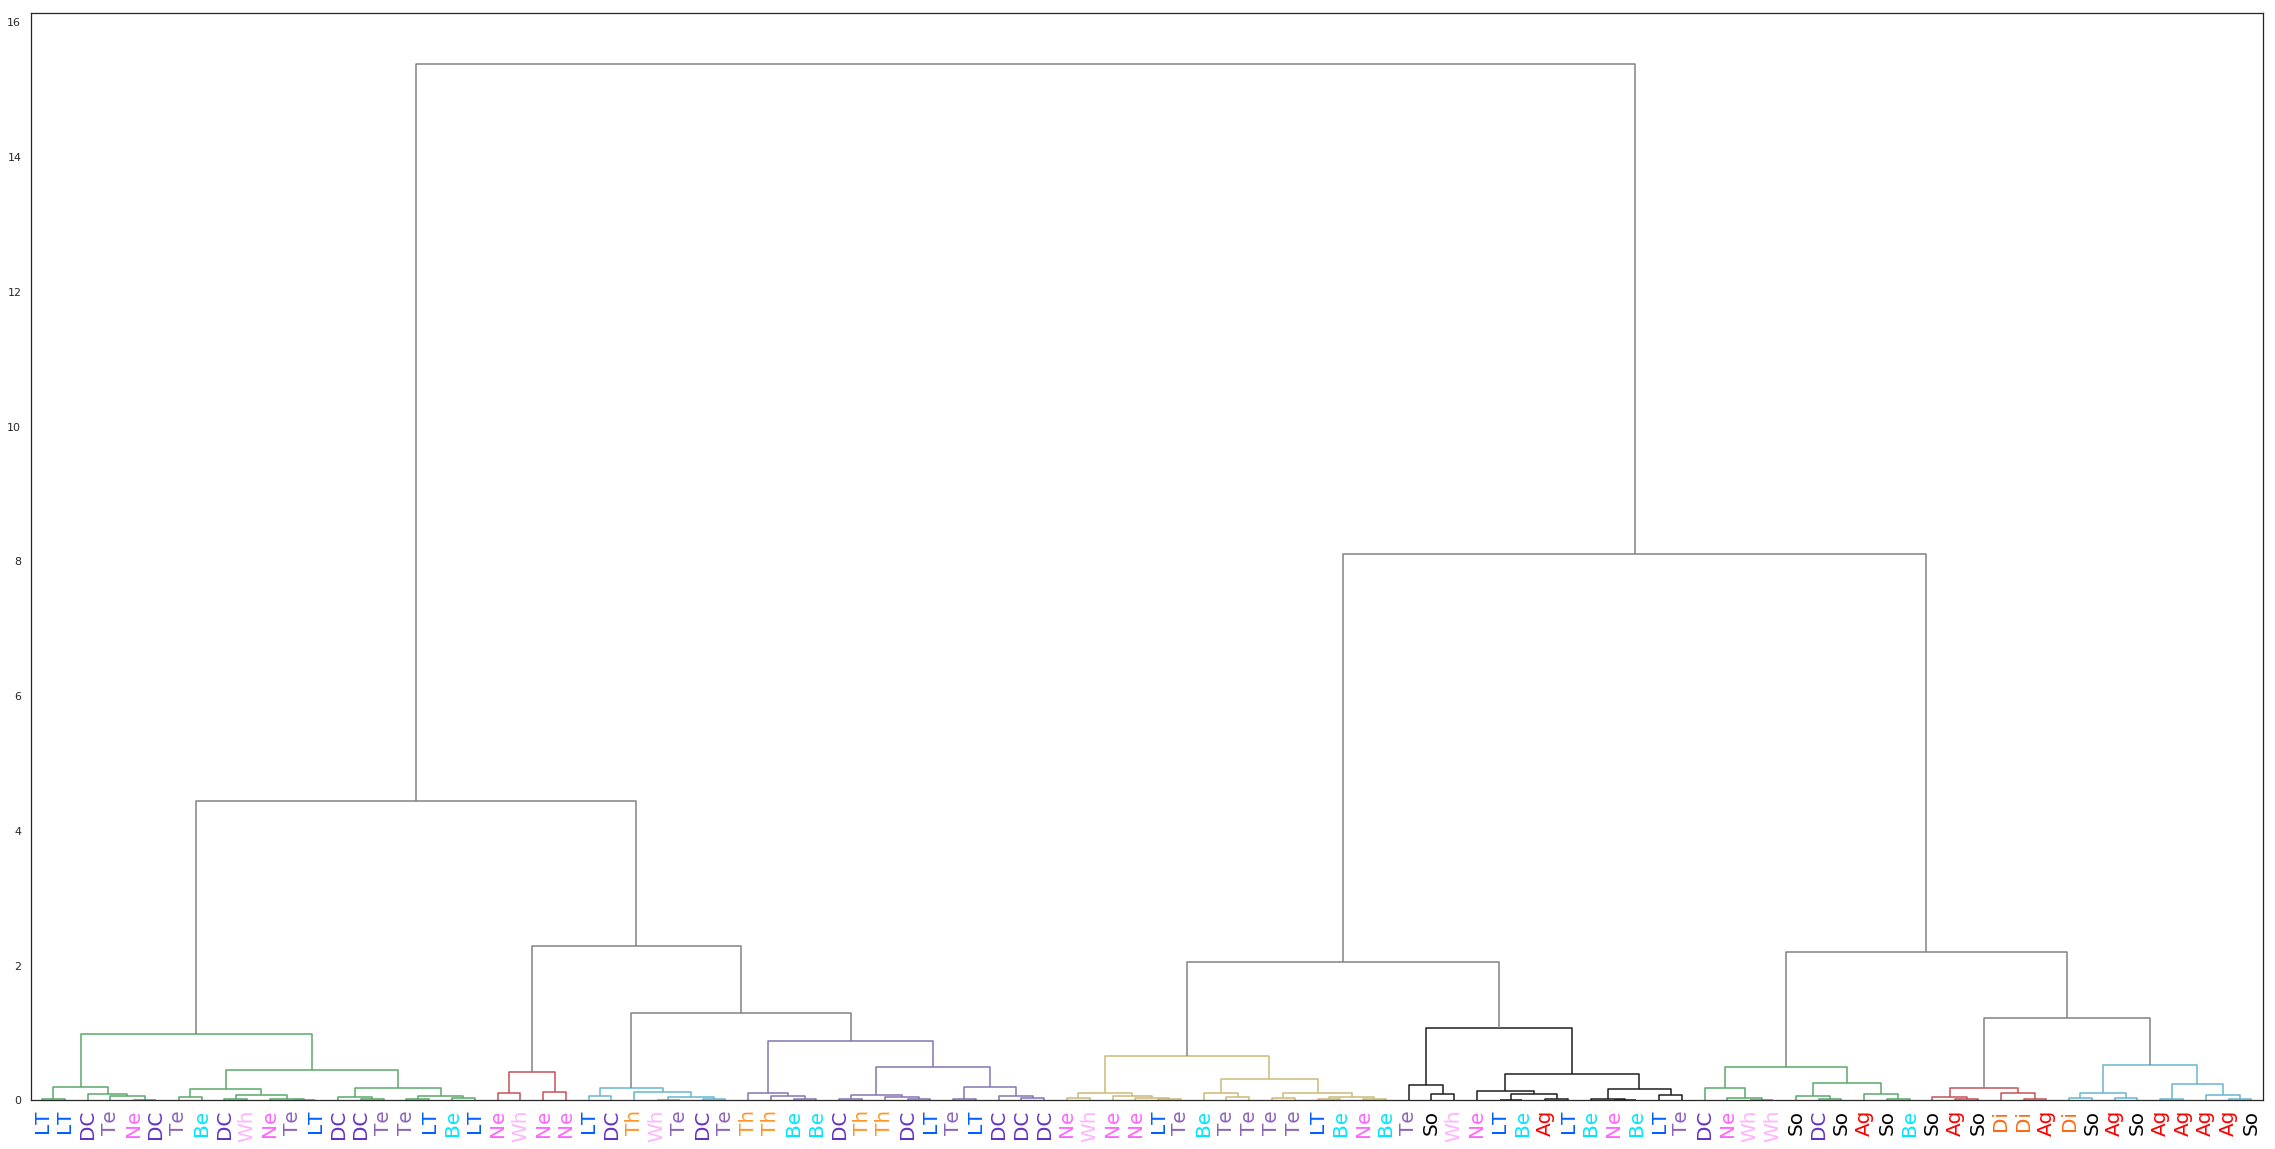

In [113]:
r = cluster_analysis(results[max_ari_ind][0][2][has_wavs],lbls,and_plot=True)
#plt.savefig("")

In [37]:
sys.getsizeof(result_dict[5])

8064

In [38]:
99*1000

99000

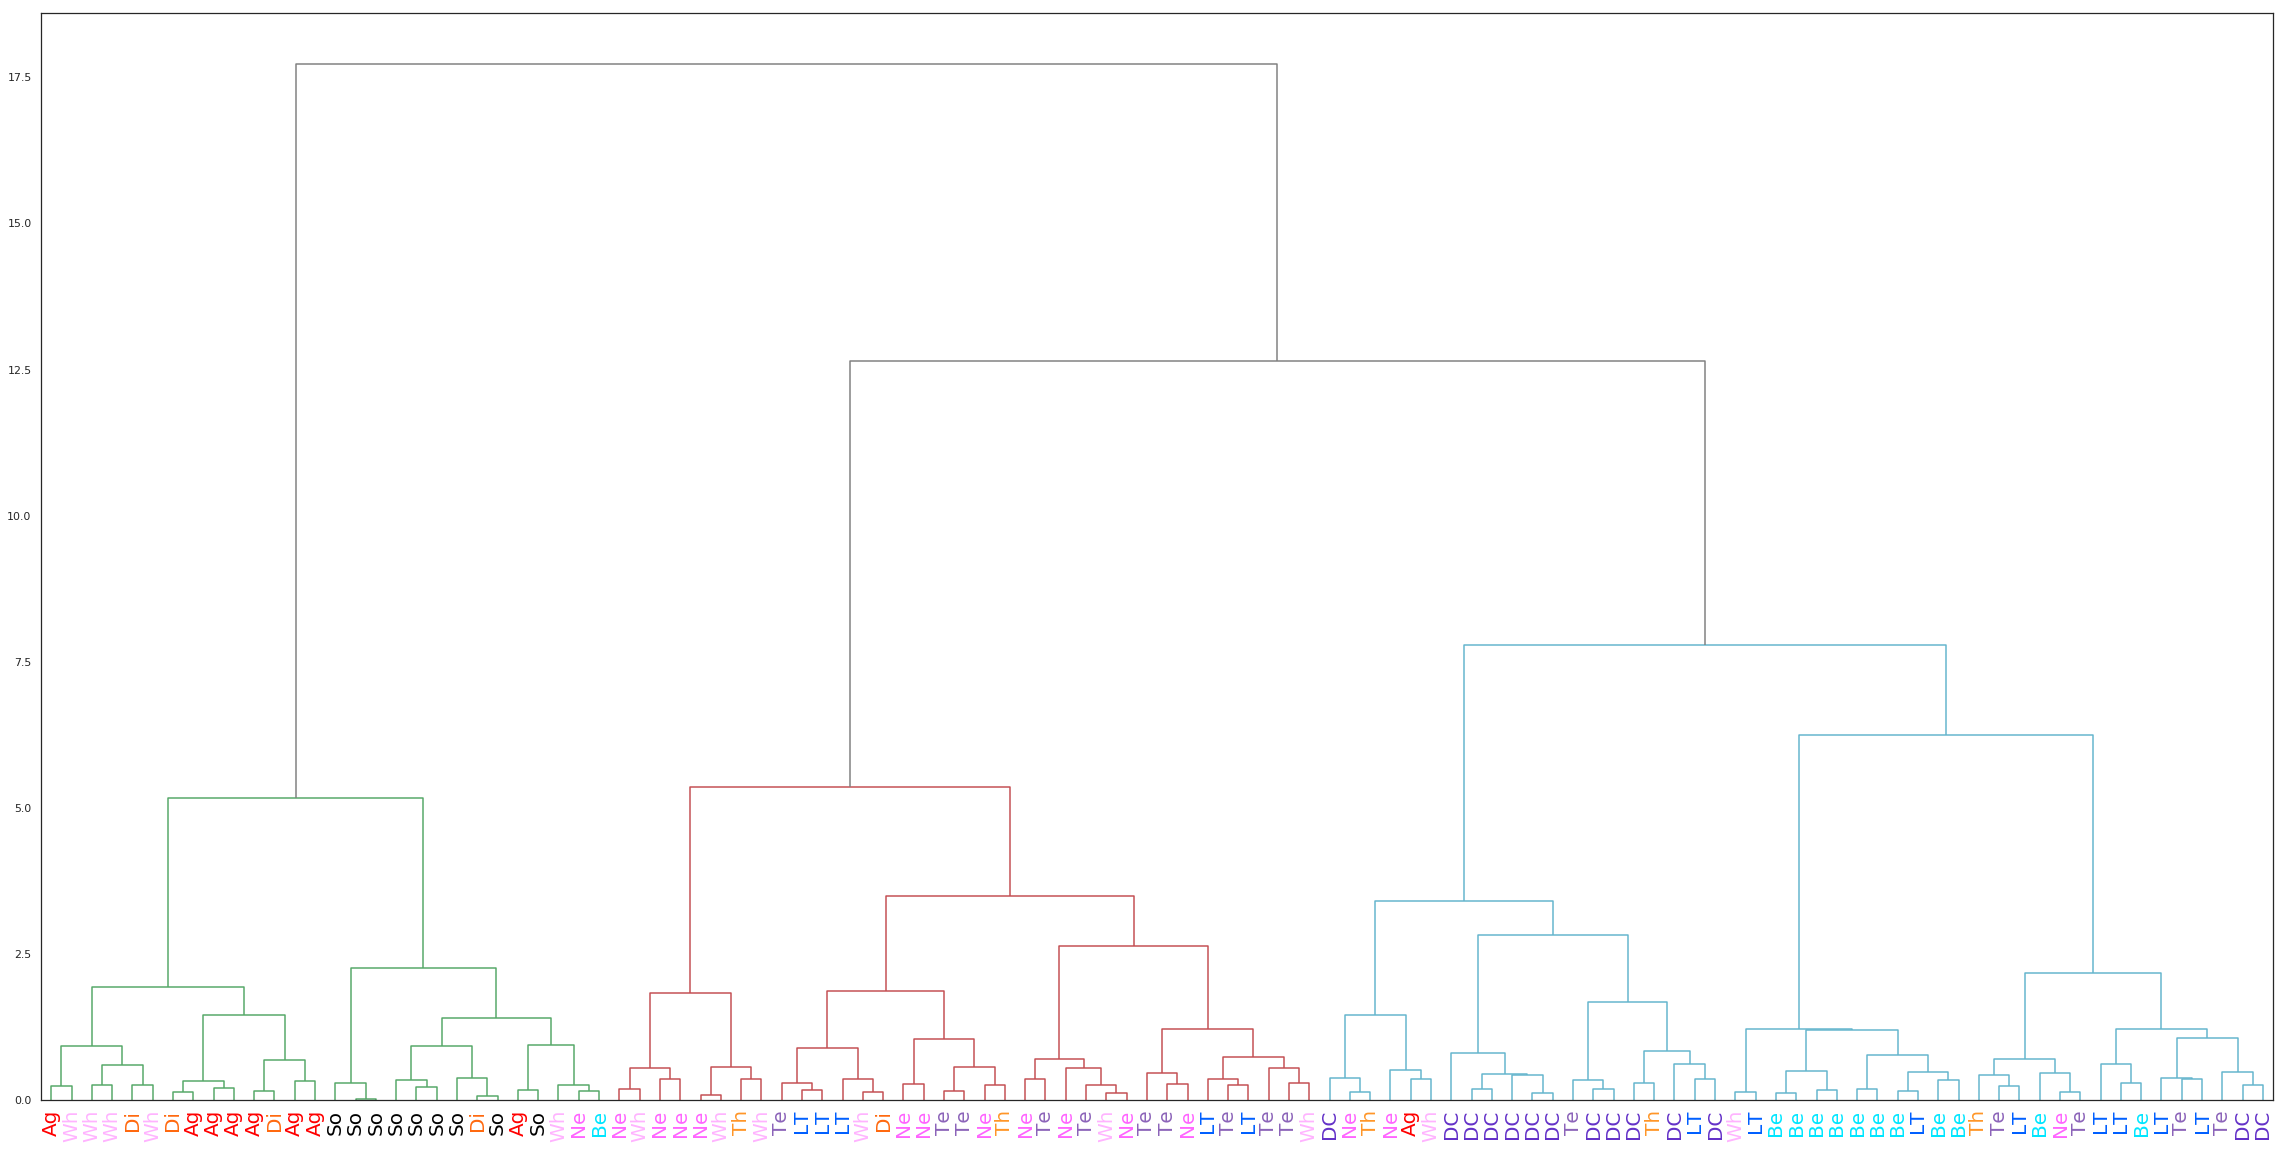

In [129]:
# for an example case we will use max ari index
max_ari_ind = np.argmax(aris)
clustered=linkage(results[max_ari_ind][0][2],method ='ward')
plt.figure(figsize= (40,20))
D = dendrogram(Z=clustered, leaf_rotation=90., 
     leaf_font_size=20., # determine number by plotting cluster colors on leaves first
     labels= results[max_ari_ind][1], #finesem_calls[1:7633],
     #labels=np.array(labels), #voc_types,#plottinglabels,
     #color_threshold= start_thresh+max_cl*delta,
     above_threshold_color='grey')
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for t in xlbls:
    t.set_color(callColor.get(t.get_text(),(0,0,0)))
plt.savefig("Test.png")

In [58]:
results[max_ari_ind][0][2].shape

(110, 2)

In [93]:
# for an example case we will use max ari index
max_aris_comp_aud = []
max_amis_comp_aud = []
for i in range(len(aris)):
    clustered=linkage(results[i][0][2][has_wavs],method ='ward')

    labels = aud_lbl_umap

    max_ari = 0
    max_ami = 0
    max_cl = 0

    delta = (clustered.max()-clustered.min())/500 #.1
    start_thresh = clustered.min()#100 #.25
    cur_grouping = None
    unique_groupings = []
    best_grouping = None
    for cl in range(1,500):
        F = fcluster(clustered, start_thresh + cl*delta, criterion='distance')
        if np.all(cur_grouping == F):
            continue
        unique_groupings.append(F)
        cur_grouping = F

        # check ari
        compares = [[],[]]
        for gid in range(max(F)):
            for j in np.where(F==gid)[0]:
                    compares[0].append(labels[j])
                    compares[1].append(gid)
        ari = adjusted_rand_score(compares[0],compares[1])
        ami = adjusted_mutual_info_score(compares[0],compares[1])
        #print("%s %s"%(ari,start_thresh + cl*delta))
        # previously just go until 10 groups
        #if max(F) < 10:
        #    break
        if ari == 1.0:# or ari == 0.0:
            break
        if ari > max_ari:
            best_grouping = cur_grouping
            max_cl = cl
            max_ari = ari
        if ami == 1.0:# or ari == 0.0:
            break
        if ami > max_ami:
            best_grouping = cur_grouping
            max_cl = cl
            max_ami = ami
    max_aris_comp_aud.append( max_ari)
    max_amis_comp_aud.append( max_ami)
max_aris_comp_aud = np.asarray(max_aris_comp_aud)
max_amis_comp_aud = np.asarray(max_amis_comp_aud)

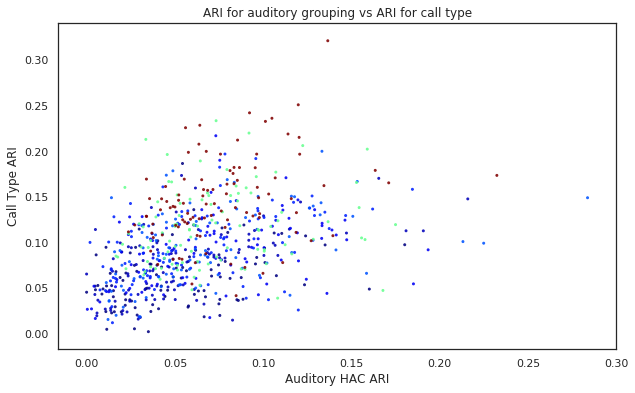

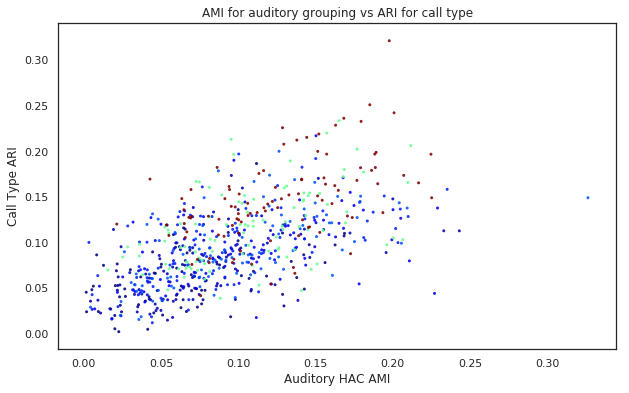

In [96]:
plt.figure(figsize=(10,6))
plt.scatter(max_aris_comp_aud,aris,c=grp_size,alpha=.8,s=4,cmap='jet')
plt.title("ARI for auditory grouping vs ARI for call type")
plt.xlabel("Auditory HAC ARI")
plt.ylabel("Call Type ARI")
plt.savefig("Figs/Group_Meeting_Figs/AudARIvsCT_ARI.png")
plt.figure(figsize=(10,6))
plt.scatter(max_amis_comp_aud,aris,c=grp_size,alpha=.8,s=4,cmap='jet')
plt.title("AMI for auditory grouping vs ARI for call type")
plt.xlabel("Auditory HAC AMI")
plt.ylabel("Call Type ARI")
plt.savefig("Figs/Group_Meeting_Figs/AudAMIvsCT_ARI.png")

In [99]:
max_aris_comp_aud = np.asarray(max_aris_comp_aud)

0.3316845701643778 0.03914697790306386
0.46561012693150383 0.039157752522024136
0.35986826129384325 0.05555139885093781
0.4183382644741028 0.057431564148611475
0.458003016076264 0.048732929549129146
0.46102552533427715 0.0665042838830057
0.5505987580357783 0.07685772951371216


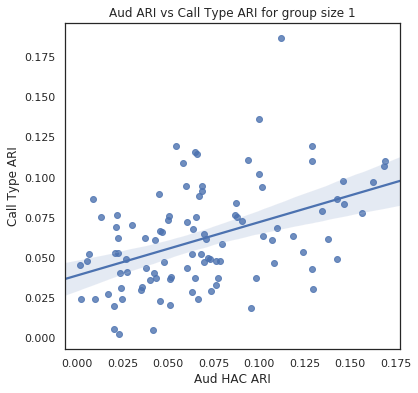

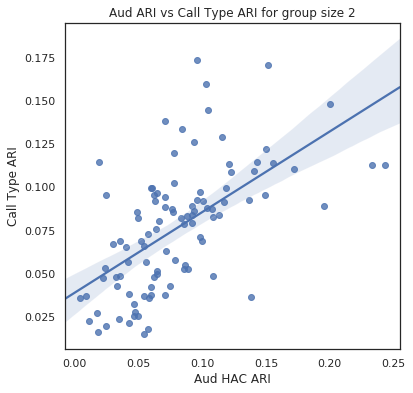

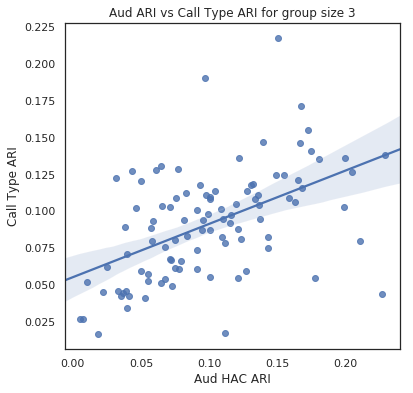

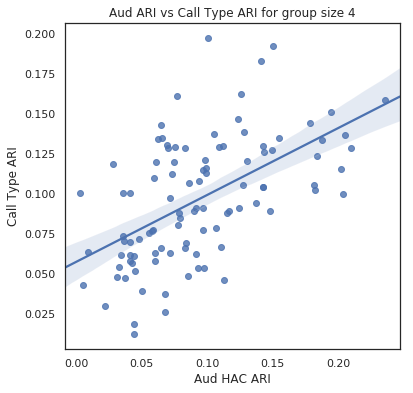

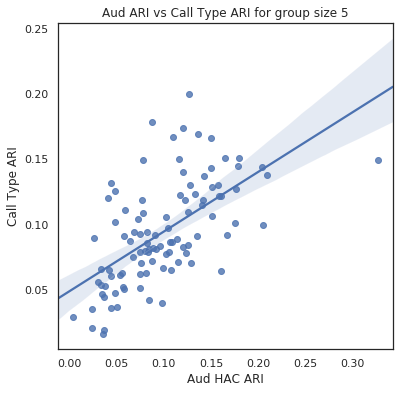

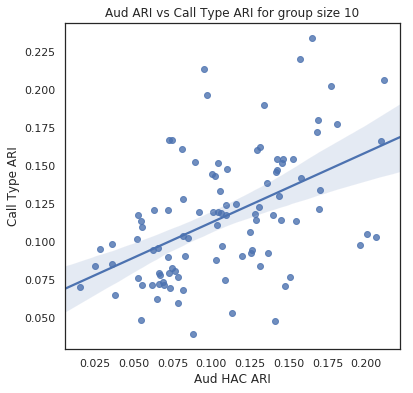

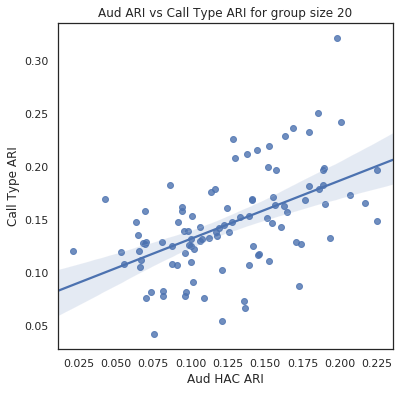

In [91]:
for gs in np.unique(grp_size):
    plt.figure(figsize=(6,6))
    plt.title("Aud ARI vs Call Type ARI for group size %s"%(gs))
    #seaborn.regplot(x=np.log10(pccs_rand[grp_size == gs+1]), y =aris[grp_size == gs+1] )
    slope, intercept, r_value, pv, se = stats.linregress(max_aris_comp_aud[grp_size == gs], aris[grp_size == gs])
    print(slope,intercept)
    seaborn.regplot(max_aris_comp_aud[grp_size == gs], aris[grp_size == gs], line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})

    plt.xlabel("Aud HAC ARI")
    plt.ylabel("Call Type ARI")
    
    plt.savefig("Figs/Group_Meeting_Figs/AudvsCT_ARI_%s.png"%gs)

0.3316845701643778 0.03914697790306386
0.46561012693150383 0.039157752522024136
0.35986826129384325 0.05555139885093781
0.4183382644741028 0.057431564148611475
0.458003016076264 0.048732929549129146
0.46102552533427715 0.0665042838830057
0.5505987580357783 0.07685772951371216


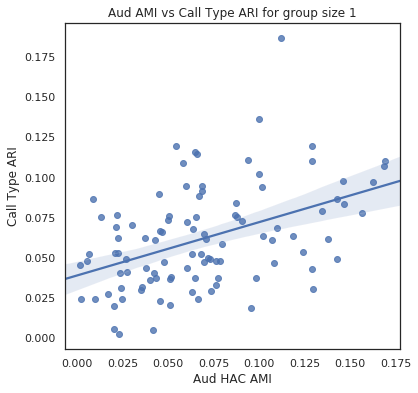

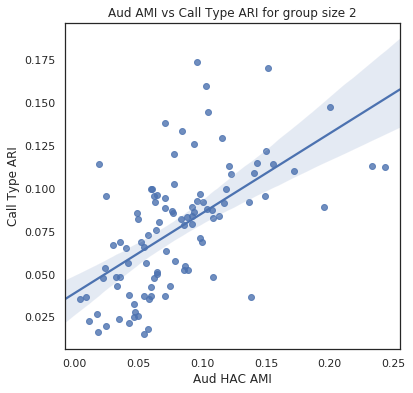

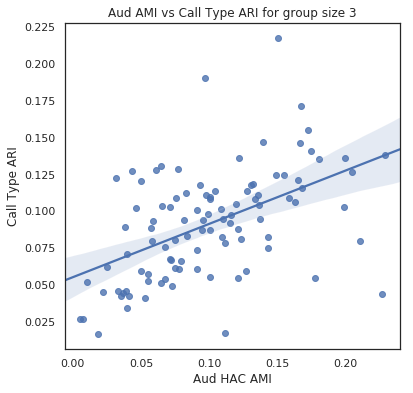

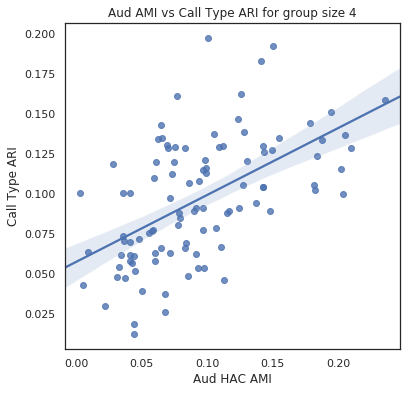

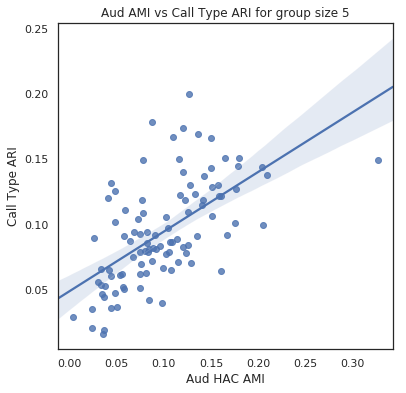

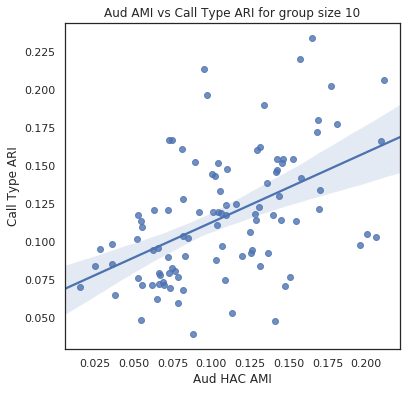

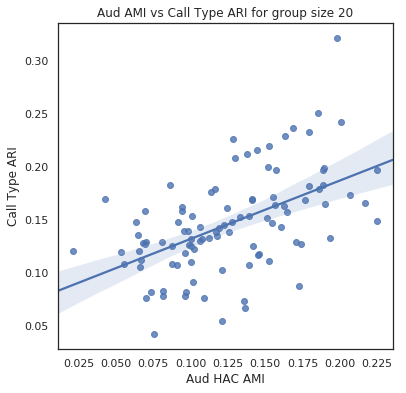

In [97]:
for gs in np.unique(grp_size):
    plt.figure(figsize=(6,6))
    plt.title("Aud AMI vs Call Type ARI for group size %s"%(gs))
    #seaborn.regplot(x=np.log10(pccs_rand[grp_size == gs+1]), y =aris[grp_size == gs+1] )
    slope, intercept, r_value, pv, se = stats.linregress(max_amis_comp_aud[grp_size == gs], aris[grp_size == gs])
    print(slope,intercept)
    seaborn.regplot(max_amis_comp_aud[grp_size == gs], aris[grp_size == gs], line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})

    plt.xlabel("Aud HAC AMI")
    plt.ylabel("Call Type ARI")
    
    plt.savefig("Figs/Group_Meeting_Figs/AudvsCT_AMI_%s.png"%gs)

Text(0, 0.5, 'PCC')

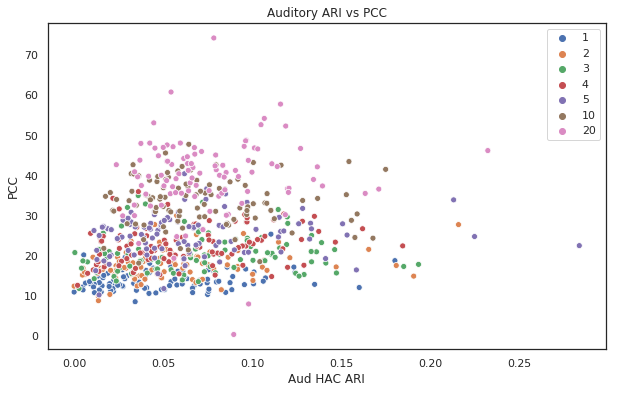

In [113]:

plt.figure(figsize=(10,6))
seaborn.scatterplot(max_aris_comp_aud, pccs_rand, grp_size,palette=seaborn.color_palette(n_colors=len(np.unique(grp_size))))
plt.title("Auditory ARI vs PCC")
plt.xlabel("Aud HAC ARI")
plt.ylabel("PCC")

0.5482763311145606 0.04468681362109283


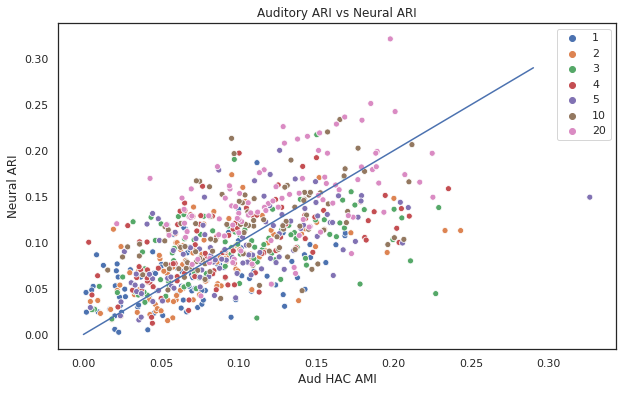

In [119]:

plt.figure(figsize=(10,6))
slope, intercept, r_value, pv, se = stats.linregress( max_amis_comp_aud, aris )
seaborn.scatterplot(max_amis_comp_aud, aris, grp_size,palette=seaborn.color_palette(n_colors=len(np.unique(grp_size))))
plt.plot(np.arange(0,.3,.01),np.arange(0,.3,.01))
plt.title("Auditory ARI vs Neural ARI")
plt.xlabel("Aud HAC AMI")
plt.ylabel("Neural ARI")
print(slope,intercept)

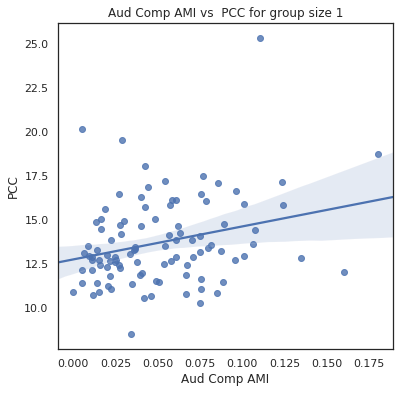

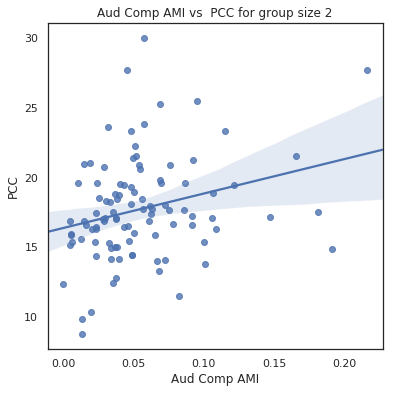

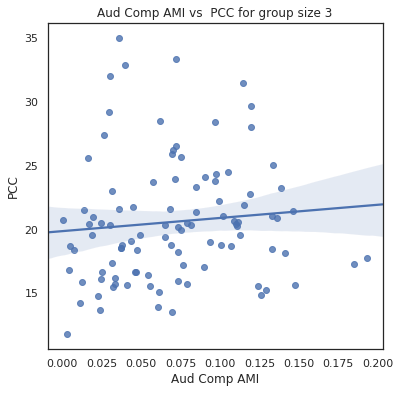

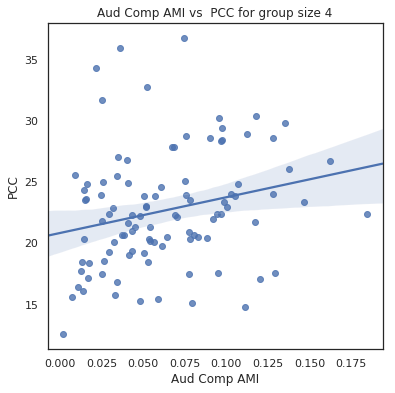

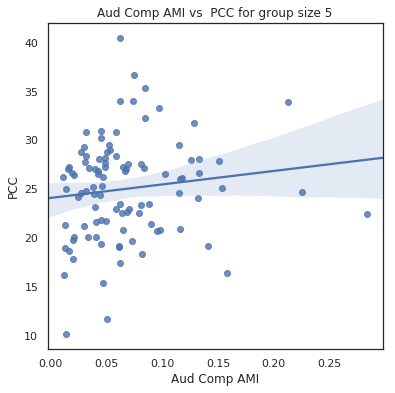

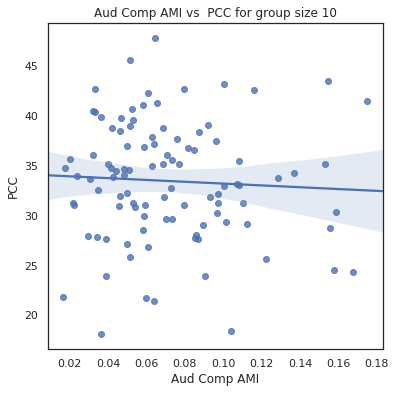

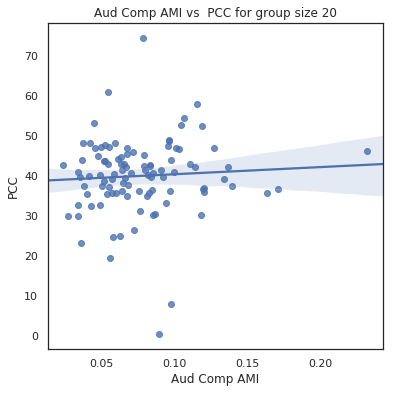

In [116]:
for gs in np.unique(grp_size):
    plt.figure(figsize=(6,6))
    plt.title("Aud Comp AMI vs  PCC for group size %s"%(gs))
    #seaborn.regplot(x=np.log10(pccs_rand[grp_size == gs+1]), y =aris[grp_size == gs+1] )
   
    seaborn.regplot( max_aris_comp_aud[grp_size == gs],pccs_rand[grp_size == gs])

    plt.ylabel("PCC")
    plt.xlabel("Aud Comp AMI")
    
    plt.savefig("Figs/Group_Meeting_Figs/PCC_AMI_%s.png"%gs)

18.52993174052876 12.437612667825086
21.114085198459083 16.028482581246145
10.33480173221987 19.572817811089365
24.02007379917427 20.433139310768816
17.584750167933233 23.29462304819173
-8.169690632086297 34.3592722305428
13.890681219002921 38.15716413582752


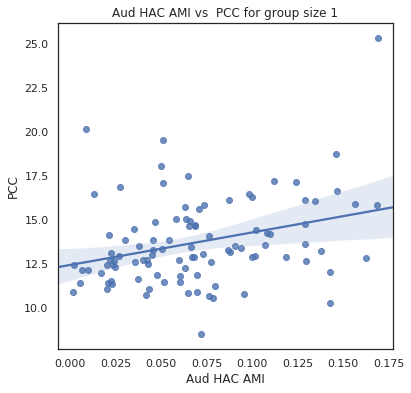

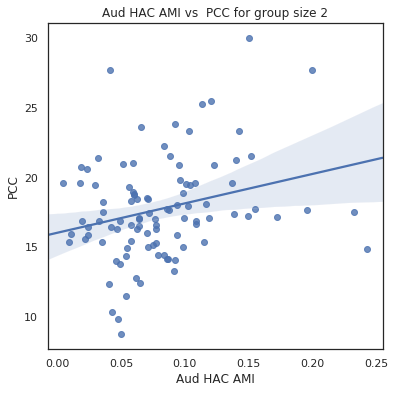

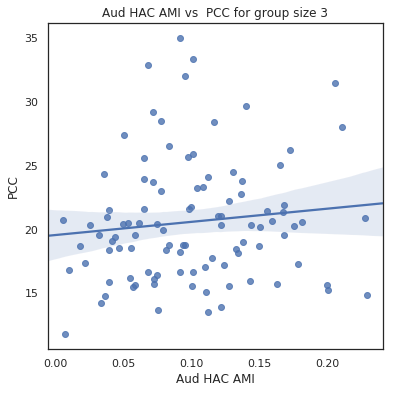

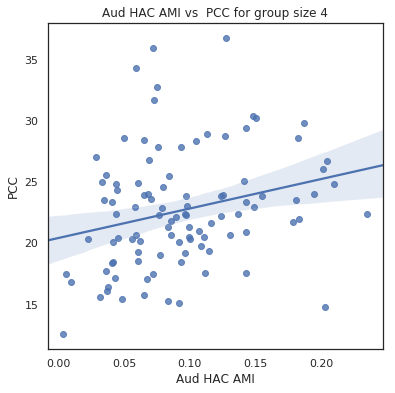

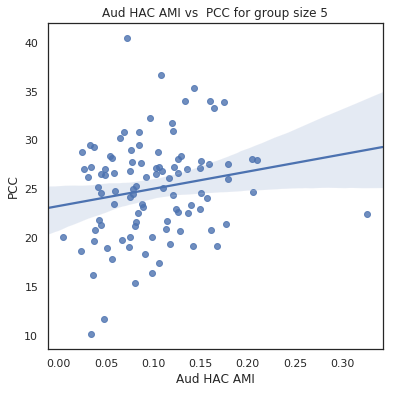

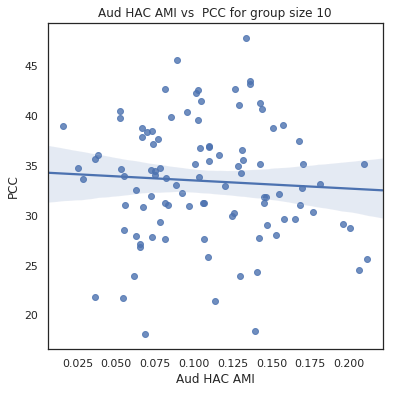

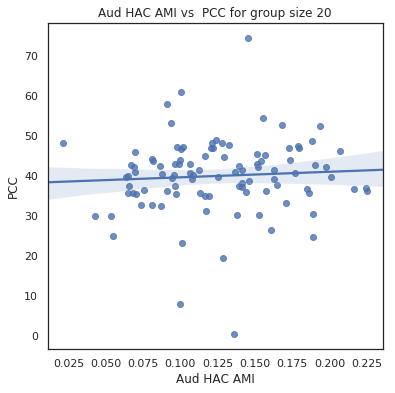

In [100]:
for gs in np.unique(grp_size):
    plt.figure(figsize=(6,6))
    plt.title("Aud HAC AMI vs  PCC for group size %s"%(gs))
    #seaborn.regplot(x=np.log10(pccs_rand[grp_size == gs+1]), y =aris[grp_size == gs+1] )
    slope, intercept, r_value, pv, se = stats.linregress( max_amis_comp_aud[grp_size == gs], pccs_rand[grp_size == gs] )
    print(slope,intercept)
    seaborn.regplot( max_amis_comp_aud[grp_size == gs],pccs_rand[grp_size == gs], line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})

    plt.ylabel("PCC")
    plt.xlabel("Aud HAC AMI")
    
    plt.savefig("Figs/Group_Meeting_Figs/AudvsPCC_AMI_%s.png"%gs)